In [2]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import sys
import os
# top_path = '..'
# if top_path not in sys.path:
#     sys.path.append(top_path)

coffea_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/'
if coffea_path not in sys.path:
    sys.path.insert(0,coffea_path)
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from coffea import util
from plotters.pltStyle import pltStyle
import mplhep as hep
pltStyle('hep')
from scipy.optimize import curve_fit
# from collections.abc import Iterable
# %matplotlib notebook 
# %matplotlib notebook 

In [4]:
from helpers import hist_add, hist_mult, hist_div, dictionary_pattern, sum_subhist, xsecstr2float
from helpers import sum_neg_pos_eta, read_data
from helpers import rebin_hist, add_flavors
from JetEtaBins import JetEtaBins, PtBins

# from common_binning import JERC_Constants

In [5]:
use_corrections = 'T' ### Which corrections to use for deriving the uncertainties 'T' for ttbar, 'J' for QCD
### If to include unmatched in calculating the uncertainties with seperate fits and
### include them in the flavor fraction plots.
### If False, unmatched are ignored
include_unmatched = False

eta_binning  = "HCalPart"  ### HCalPart, CoarseCalo, CaloTowers, onebin;        HCalPart: bin in HCal sectors, CaloTowers: the standard JERC binning, CoarseCalo: like 'CaloTowers' but many bins united;

In [6]:
color_scheme = {key: cycler_vals
    for cycler_vals, key in zip(plt.rcParams['axes.prop_cycle'], ['g', 'q', 'c', 'b', 'QCD', 'DY', 'TTBAR', 'DY200', 'unmatched'])}

leggend_dict = {'g': 'Gluons', 'q': 'Quarks', 'b': 'Bottom', 'c': 'Charm', 'unmatched': 'Unmatched'}
leggend_dict_short = {'g': 'g', 'q': 'uds', 'b': 'b', 'c': 'c', 'unmatched': 'unmatched'}

In [7]:
color_scheme['unmatched'] = {'color': '#e5e562', 'marker': 's'}

In [8]:
# plt.rcParams['figure.dpi']=200

In [9]:
def get_output(data_tag):
    ''' Load response histogram data with the tag `data_tag`
    '''
    tag_full = '_L5'+data_tag
    outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'
    output = util.load(outname)
    return output

In [10]:
def get_file_dict(data_tag):
    ''' Load a text file with cross sections and file names as a dictionary `file_dict`.
    '''
    if "_QCD-MG" in data_tag:
        if data_tag=='_DY-MG-Her':
            dataset_list_file = 'fileNames/QCD_Herwig_20UL18/xsecs_QCD_Herwig_corrected.txt'
        else:
            dataset_list_file = 'fileNames/QCD_MG_Py8_20UL18/xsecs_QCD_MG_py8.txt'
        with open(dataset_list_file) as f:
            lines = f.readlines()
        lines_split = [line.split() for line in lines]
        file_dict = {data_tag[1:]+'_'+lineii[1]: xsecstr2float(lineii[2]) for lineii in lines_split }
    else:
        file_dict = 1
    return file_dict

In [11]:
# output_orig = output
def sum_output(output, data_tag, file_dict):
    ''' If the file with histograms `output` contains a dictionary over many datasets (e.g. different pt ranges),
    sum them up proportionally to the cross sections in `file_dict` 
    Output: summed up hisograms `output`
    '''
    if "_QCD-MG" in data_tag:
        response_sums = {key:sum(dictionary_pattern(output[key], "ptresponse_").values()).sum().value for key in output.keys()}
        scale_factors = hist_div(file_dict, response_sums)
        all_histo_keys = output[next(iter(output.keys()))].keys()
        result = {histo_key:sum_subhist(output, histo_key, scale_factors) for histo_key in all_histo_keys }
        output = result
    elif len(output.keys())==1:
        output = output[list(output.keys())[0]]
    return output

In [12]:
# #JetEtaBins.py
# from common_binning import JERC_Constants
# from dataclasses import dataclass, field
# import numpy as np

# @dataclass()
# class JetEtaBins():
#     bin_type: str = "Win14"
#     edges:   np.ndarray = field(init=False, repr=True)
#     centres: np.ndarray = field(init=False, repr=True)
#     nbins:   np.ndarray = field(init=False, repr=True)


#     def __post_init__(self):
#         bin_dict = JERC_Constants.StrToBinsDict()
#         if not self.bin_type in bin_dict.keys():
#             raise ValueError(f"The eta bin type not in available binnings. Available binnings: {bin_dict.keys()}. The key given {self.bin_type}")
#         self.edges = np.array(bin_dict[self.bin_type])
#         self.centres = (self.edges[:-1] + self.edges[1:])/2
#         self.nbins = len(self.centres)

#     def idx2plot_str(self, etaidx, precision=3):
#         outstr = f'$ {np.round(self.edges[etaidx],precision)}<\eta<{np.round(self.edges[etaidx+1],precision)}$'
#         return outstr

#     def idx2_str(self, etaidx, precision=3):
#         outstr = f'eta{np.round(self.edges[etaidx],precision)}to{np.round(self.edges[etaidx+1],precision)}'
#         return outstr
    
#     def get_bin_idx(self, etavals):
#         if not type(etavals) is np.ndarray:
#             etavals = np.array(etavals)
#         if len(etavals.shape)==0:
#             etavals = np.array([etavals])
#         indx = np.searchsorted(self.edges, etavals, side='right')-1
#         return np.clip(indx,0,len(self.edges)-2)
    
#     def set_centres(self, centres: np.ndarray):
#         if not len(centres)==self.nbins:
#             raise ValueError(f"The length of given centres values is not equal to the number of bins, nbins = {self.nbins}")

#         self.centres = np.array(centres)




In [13]:
# def check_bins(hist, jetetabins, ptbins):
#     if len(hist.axes['pt_gen'].centers) != ptbins.nbins or np.any((hist.axes['pt_gen'].centers-ptbins.centres)/ptbins.centres>1e-7):
#         raise RuntimeError('The pre-defined pt bins bins ar incompatible with the bins in the histogram. \n pt bins centres: '+str(ptbins.centres)+', \n histogram pt bins'+str(hist.axes['pt_gen'].centers))
#     if len(hist.axes['jeteta'].centers) != etabins.nbins or np.any((hist.axes['jeteta'].centers-jetetabins.centres)/jetetabins.centres>1e-7):
#         raise RuntimeError(f'The pre-defined jet eta bins ar incompatible with the bins in the histogram.')
    

In [14]:
# fine_etabins = False    ### If True use JERC default binning, if False, use the Run 1 binning (binning in HCal sectors)
# one_bin = False         ### If True, combine all the eta bins in one bin
# if eta_binning=="CaloTowers":
#     fine_etabins = True    ### If True use JERC default binning, if False, use the Run 1 binning (binning in HCal sectors)
# if eta_binning=="onebin":
#     one_bin      = True    ### If True, combine all the eta bins in one bin
    
jeteta_bins = JetEtaBins(eta_binning)
pt_bins = PtBins("MC_truth")

fineetastr = '_fineeta' if eta_binning=="CaloTowers" else ''

# data_tag = '_Pythia-TTBAR' ##an exmaple file, used only to get the etabins
# output = get_output(data_tag)
# file_dict = get_file_dict(data_tag)
# output = sum_output(output, data_tag, file_dict)
# ## find the first response histogram to extract the axes
# for key in output.keys():
#     if 'response' in key:
#         response_key = key
#         break

# from common_binning import JERC_Constants
# ptbins = output[response_key].axes["pt_gen"].edges 
# ptbins_c = output[response_key].axes['pt_gen'].centers
# etabins = output[response_key].axes["jeteta"].edges
# if one_bin==True:
# #     ptbins = np.array([ptbins[0], ptbins[-1]])
#     ptbins_c = (ptbins[:-1]+ptbins[1:])/2
#     etabins = np.array([etabins[0], 0, etabins[-1]])
# elif not fine_etabins:
#     etabins = np.array(JERC_Constants.etaBinsEdges_Aut18_full())
#     etabins = np.array(JERC_Constants.etaBinsEdges_Win14_full())
    
# jetpt_length = len(ptbins)-1
# jeteta_length = (len(etabins)-1)//2

# etabins_abs = etabins[(len(etabins)-1)//2:]
# etabins_c = (etabins_abs[:-1]+etabins_abs[1:])/2 #output['ptresponse'].axis('jeteta').centers()
# etabins_c[0] = etabins_abs[0]
# etabins_c[-1] = etabins_abs[-1]-0.001

### Sum together all the different flavors

In [15]:
def combine_flavors(output, sumeta=True, include_unmatched=True):
    flavors = (['g', 'c', 'b', 'q', 'unmatched', 'all_unmatched'] if include_unmatched==True
               else ['g', 'c', 'b', 'q', 'all'])
    hists = {}
    for flav in flavors:
        combined = add_flavors(output, flavor=flav, combine_antiflavour=True )[0]
        if sumeta:
            combined = combined[:,sum,sum]
        else:
            combined = combined[:,sum,:]
        flav2 = flav if not flav=='all_unmatched' else 'all'
        hists[flav2] = combined
    return hists
 

In [16]:
from scipy.optimize import curve_fit

def poly4(x, *p):
    c0, c1, c2, c3, c4 = p
    xs = np.log10(x)
    res = c0+c1*xs+c2*xs**2+c3*xs**3+c4*xs**4
    return res

def fit_Efractions(qfracs):
    fit_res = []
    for etaidx in range(len(qfracs[0])):
        qfrac = qfracs[:,etaidx]
        valid_fit_val = ~(np.isnan(qfrac) | np.isinf(qfrac) | (qfrac==0))
        ptbins_c_plot = ptbins_c[valid_fit_val]

        if not 'unmatched' in flav:
            p, arr2 = curve_fit(poly4, ptbins_c_plot, qfrac[valid_fit_val], p0=[1,1,1,1, 1]) #, sigma=np.sqrt(qfrac_var2[flav])[valid_fit_val])
        else:
            p, arr2 = curve_fit(poly4, ptbins_c_plot, qfrac[valid_fit_val], p0=[1,1,1,1, 1])

        if len(fit_res)==0:
            fit_res = p
        else:
            fit_res = np.vstack([fit_res, p])

    return fit_res

# fit_Efractions(qfracs2['q'])

In [17]:
ptmin_global = 30
ptmax_global = 500

In [18]:
from dataclasses import dataclass, field

def convert_to_np_array(var):
    if not type(var) is np.ndarray:
        var = np.array(var)
    if len(var.shape)==0:
        var = np.array([var])
    return var

@dataclass
class FlavorFractions():
    E_frac_splines: dict
    binning: str = "Win14"
        
    flavors: str = field(init=False, repr=True)
    def __post_init__(self):
        if not isinstance(self.E_frac_splines, dict):
            raise TypeError(f"The argument in E_frac_splines has to be a dictionary over the flavors. The given type is {type(self.E_frac_splines)}")
        self.flavors = np.array([key for key in self.E_frac_splines.keys()])
  
    def evaluate(self, flav, etavals, ptvals):
        ''' Evaluate the flavor fractions for flavor `flav` and at `etavals` and `ptvals`
        '''
        splines = self.E_frac_splines[flav]
        
        etavals = np.abs(etavals)
        etavals = convert_to_np_array(etavals)
        ptvals = convert_to_np_array(ptvals)
                    
        ptvals = np.clip(ptvals, ptmin_global, ptmax_global)
        logptvals = np.log10(ptvals)
        eta_idxs = JetEtaBins(self.binning).get_bin_idx(etavals) #JERC_Constants.GetEtaBinIdx(etavals, self.binning)        
        #usually quicker to loop over the same eta indices at the same time than through all the incides
        outs = np.ones(shape=(etavals.size), dtype=np.float32)
        for i in np.unique(eta_idxs): 
            mask = np.where(eta_idxs == i)
            splineii   = splines[i]
            logptvalsii   = logptvals[mask]
            logptvalsii  = np.clip(logptvalsii, np.min(splineii.x), np.max(splineii.x) )
            
            outs[mask] = splineii(logptvalsii)
        return outs

In [19]:
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator

def get_spline(yval):
    valid_fit_val = ~(np.isnan(yval) | np.isinf(yval) | (yval==0))
    ptbins_c_plot = pt_bins.centres[valid_fit_val]
    yval = yval[valid_fit_val]

    spline_func = CubicSpline(np.log10(ptbins_c_plot), yval, bc_type='natural', extrapolate=False )
    return spline_func

# def evaluate_spline(spline, ptval):
#     ptlims_spline = spline.x
#     ptmi = np.min(ptlims_spline)
#     ptma = np.max(ptlims_spline)
#     logptval = np.log10(ptval)
#     logptval = ptmi if logptval<ptmi else ptma if logptval > ptma else logptval
#     return spline(logptval)

# def evaluate_splines(splines, etavals, ptvals):
#     ''' 
#     '''
#     etavals = np.abs(etavals)
#     if not isinstance(ptvals, Iterable):
#         ptvals = np.array([ptvals])      
#     if not isinstance(etavals, Iterable): #(type(etaidx) is list) or (type(etaidx) is np.ndarray):
#         etavals = np.array([etavals])
#     ptvals = ptvals.copy()
#     ptvals[ptvals<30]=30
#     ptvals[ptvals>500]=500
    
#     eta_idxs = np.searchsorted(etabins_abs, etavals, "right")-1
#     eta_idxs[eta_idxs<0] = 0
#     eta_idxs[eta_idxs>=len(etabins_abs)-1] = len(etabins_abs)-2
    
#     splines_eta = splines[eta_idxs]
#     result = np.array([evaluate_spline(splineii, ptval) for splineii, ptval in zip(splines_eta,ptvals)])
        
#     return result

In [20]:
def plot_Efractions(sampledict, etaidx, etabins, ptbins, saveplot=False):
    samples = list(sampledict.keys())
    ptbins_c = ptbins.centres

#     ### Check that Herwig is the first sample and Pythia the second
#     if not ('Her' in samples[0] and 'Py' in samples[1]):
#         raise ValueError('key in the dictionary happened to get reversed')
    
    
    qfracs0, qfrac_var0, spline0, spline2D0 = sampledict[samples[0]]
    qfracs1, qfrac_var1, spline1, spline2D1 = sampledict[samples[1]]
    
    plot_range = range(0, np.searchsorted(ptbins_c,1250)) if 'DY' in "".join(samples) else range(0, np.searchsorted(ptbins_c,2750))
    ptbins_c_plot = ptbins_c[plot_range]
    
    fig, ax = plt.subplots()
    xplot = np.geomspace(ptbins_c_plot.min() - (1), ptbins_c_plot.max(),1000)
    xplot2 = np.geomspace(ptbins_c_plot.min(), ptbins_c_plot.max(),1000)
    points_ls = []
    for flav in qfracs0.keys():
        lab = leggend_dict_short[flav]
#         mc = next(ax._get_lines.prop_cycler)

        points = ax.errorbar(ptbins_c_plot, qfracs0[flav][plot_range, etaidx],
                             yerr=np.sqrt(qfrac_var0[flav][plot_range, etaidx]),
                             linestyle='none', label=lab,  **color_scheme[flav], capsize=1.6, capthick=0.7, linewidth=1.0)
        points2 = ax.errorbar(ptbins_c_plot, qfracs1[flav][plot_range, etaidx],
                              yerr=np.sqrt(qfrac_var1[flav][plot_range, etaidx]),
                              linestyle='none', mfc='none', markeredgewidth=1.2, **color_scheme[flav], capsize=1.6, capthick=0.7, linewidth=1.0)

        valid_fit_val = ~(np.isnan(qfracs1[flav]) | np.isinf(qfracs1[flav]) | (qfracs1[flav]==0))
        
#         ax.plot(xplot, spline0[flav](np.log10(xplot)), '--', markersize=0, **mc, linewidth=1.0)
#         sp1 = ax.plot(xplot, spline1[flav](np.log10(xplot)), '--', markersize=0, **mc, linewidth=1.0)
        ax.plot(xplot2, spline2D0[flav]((np.log10(xplot2), np.repeat([etabins.centres[etaidx]],len(xplot2)))),
                      '-.', markersize=0, **color_scheme[flav], linewidth=1.0)
        ax.plot(xplot2, spline2D1[flav]((np.log10(xplot2), np.repeat([etabins.centres[etaidx]],len(xplot2)))),
              '-.', markersize=0, **color_scheme[flav], linewidth=1.0)
# interp((np.log(np.arange(20,60,2)),[1]*20))
        if 'g' == flav:
            points_ls.append(points[0])
            points_ls.append(points2[0])
        
    
    ax.set_xscale('log')
    ax.set_xlabel('$p_{T,Gen}$ (GeV)')
    ax.set_ylabel("Flavor fraction")
# fig.suptitle("Blaaah $x^2_5$")

    xlims = ax.get_xlim()

    ax.set_xticks([])
    ax.set_xticks([10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    # ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    legend1 = ax.legend(points_ls, [samples[0][1:], samples[1][1:]], loc="upper left", bbox_to_anchor=(0.48, 1))
    leg2 = ax.legend(ncol=1, loc='upper right', bbox_to_anchor=(0.52, 1))
    ax.add_artist(legend1)
    # ax.add_artist(leg2)

    ylims = ax.get_ylim()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims[0], ylims[1]*1.25)

    # ax.yaxis.get_ticklocs(minor=True)
    ax.minorticks_on()
#     hep.cms.label("Something", data=False, year=2018, fontsize=15.6/1.25)
#     hep.cms.label(data=False, fontsize=15.6/1.25, loc=3)
    hep.label.exp_text(text=etabins.idx2plot_str(etaidx), loc=0)

    if saveplot:
        if not os.path.exists("fig/fractions"):
            os.mkdir("fig/fractions")

        fig_name = 'fig/fractions/fraction'+"".join(samples)
        print("Saving plot with the name = ", fig_name)
        plt.savefig(fig_name+'.pdf');
        plt.savefig(fig_name+'.png');

1;

### Get the splines of the flavor fractions

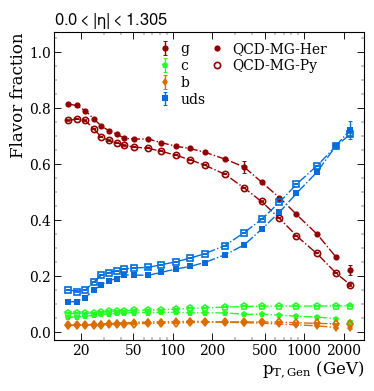

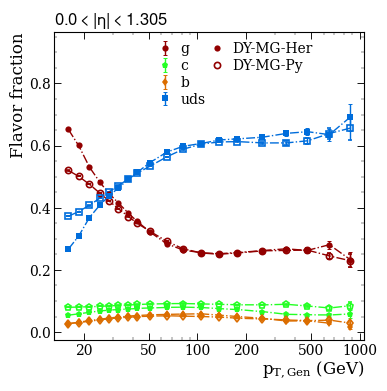

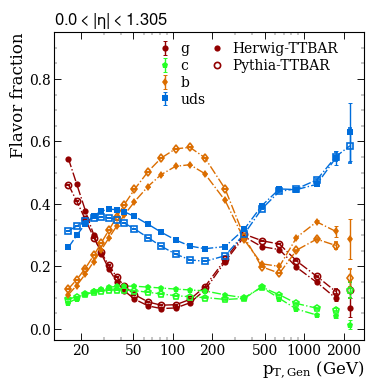

In [21]:
eta_idx = jeteta_bins.get_bin_idx(0)
flavors = ['g', 'c', 'b', 'q'] #, 'unmatched']
samples = ['QCD', 'DY', 'TTBAR']
Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']

samples = ['QCD', 'DY', 'TTBAR']
Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']

qfrac_dict = {}
qfrac_var_dict = {}
qfrac_spline_dict = {}
# qfrac_spline_dict2 = {}
qfrac_spline_dict2D = {}
# include_unmatched = True
flavors = ['g', 'c', 'b', 'q', 'unmatched'] if include_unmatched==True else ['g', 'c', 'b', 'q']
saveplot = include_unmatched

for ii in range(len(samples)):
    sampHer = Her_samples[ii]
    sampPy = Py_samples[ii]
    samp = samples[ii]
    sample_plot = {}
    
    for sample in [sampHer, sampPy]:
        output = get_output(sample)
        file_dict = get_file_dict(sample)
        output = sum_output(output, sample, file_dict)
        hists = combine_flavors(output, sumeta=False)
#         check_bins(hists[flavors[0]], jeteta_bins, pt_bins)
            
        hists_rebinned = {flav: rebin_hist(sum_neg_pos_eta(hists[flav]), 'jeteta', jeteta_bins.edges) for flav in hists.keys() }
        if include_unmatched==False: #recalculate the all
            hists_rebinned['all'] = sum([hists_rebinned[flav] for flav in flavors])

        hists_vals = {}
        for flav in hists_rebinned.keys():
            vals = hists_rebinned[flav].values()
            vals[vals==0] = np.nan
            hists_vals[flav] = vals
        qfracs = {flav: hists_vals[flav]/hists_vals['all'] for flav in flavors}
#         qfracs_var = {flav: hists_rebinned[flav].variances()/hists_rebinned['all'].variances() for flav in flavors}
        qfrac_var = {'all': hists_rebinned['all'].variances()/hists_vals['all']**2}
        for flav in flavors:
            qfrac_var[flav] = qfracs[flav]**2*(hists_rebinned[flav].variances()/hists_vals[flav]**2 + qfrac_var['all']**2)
        
        Efrac_splines = {key: 
                         np.array([get_spline(qfracs[key][:,eta_idx]) 
                          for eta_idx in range(jeteta_bins.nbins)
                         ])
                        for key in qfracs.keys()
                        }
        Efrac_2Dsplines = {key: RegularGridInterpolator((np.log10(pt_bins.centres), jeteta_bins.centres), qfracs[key], fill_value=None) 
                          for key in qfracs.keys()}
        
#         yval = qfracs['g'][:,0]


#         Efrac_fit_dict[sample] = Efrac_fits
        qfrac_dict[sample] = qfracs
        qfrac_var_dict[sample] = qfrac_var
        qfrac_spline_dict[sample] = FlavorFractions(Efrac_splines, eta_binning) #Efrac_splines #Efrac_2Dsplines
#         qfrac_spline_dict2[sample] = Efrac_splines
        
        qfrac_spline_dict2D[sample] = Efrac_2Dsplines
        sample_plot[sample] = [qfracs, qfrac_var, Efrac_splines, Efrac_2Dsplines]

    plot_Efractions(sample_plot, eta_idx, jeteta_bins, pt_bins, saveplot=saveplot)
#         correction_dict[sample] = {flav: read_corrections(sample, flav) for flav in flavors}


### Deriving the uncertainties

In [22]:
def read_data2(name, sample, flav):
    data = read_data(name, flav, "_L5"+sample+fineetastr)
    data[data==0] = np.nan
    return data

In [23]:
def read_corrections(sample, flav):
    data = read_data("Median", flav, "_L5"+sample+fineetastr)
    data[data==0] = np.nan
    return 1/data

#### Obtain the fitted corrections

In [24]:
# flavors = ['g', 'c', 'b', 'q', 'unmatched']
from coffea.lookup_tools import extractor
corr_loc_Sum20_Py = [f"* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Py{fineetastr}_pt30to500.txt"]
corr_loc_Sum20_Her = [f"* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her{fineetastr}_pt30to500.txt"]

ext = extractor()
ext.add_weight_sets(corr_loc_Sum20_Py+corr_loc_Sum20_Her)
ext.finalize()
evaluator = ext.make_evaluator()

In [25]:
plt.rcParams['figure.subplot.top'] = 0.93
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['figure.subplot.left'] = 0.176

In [26]:
# plt.rcParams['figure.subplot.left']

In [27]:
def poly4(x, *p):
    c0, c1, c2, c3, c4 = p
    xs = np.log10(x)
    res = c0+c1*xs+c2*xs**2+c3*xs**3+c4*xs**4
    return res

In [28]:
def poly4lims(x, xmin, xmax, *p):
    xcp = x.copy()
    lo_pos = xcp<xmin
    hi_pos = xcp>xmax
    xcp[lo_pos] = xmin
    xcp[hi_pos] = xmax
    return poly4(xcp, *p)
    
        


In [29]:
def get_ratio(a, b, divide=True):
    '''To obtain the JEC uncertainty instead of dividing Herwig by Python, the samples are subtracted'''
    if divide:
        return(a/b)
    else:
        return(a-b)

In [30]:
color_scheme2 = color_scheme.copy()
color_scheme2['QCD, 3 jets'] = {'color': 'brown', 'marker': 'o'}
color_scheme2['DY, 2 jets'] = {'color': 'cyan', 'marker': 'o'}

In [31]:
def plot_ratio_comparisons_samples(flav, etaidx, etabins, ptbins_c, fit_samp='J'):
    ''' Put ratio plots of many all flavors at the same place. Reproduce Fig. 31 in arXiv:1607.03663
    Output, polynomial coeficients of the data ratio fit
    '''

    divide=False
    inverse=False   #True if plot corrections, False if plot responses
    use_recopt=False   #True if use reco pt, False if use gen pt
        
    mean_name = "Median"
    mean_name_std = mean_name+'Std'
    start = np.searchsorted(ptbins_c, 16, side='left')
    end = 27
#     etaidx = np.searchsorted(etabins_abs, 0, side='left')
    
    # tag1 = '_L5_DY-MG-Py'
    # tag2 = '_L5_DY-MG-Her'
#     denom_samples = ['_QCD-MG-Py', '_QCD-MG-Py_leading_jets', '_Pythia-TTBAR', '_DY-MG-Py', '_DY-MG-Py_leading_jets'] #]
#     samples = ['_QCD-MG-Her', '_QCD-MG-Her_leading_jets', '_Herwig-TTBAR', '_DY-MG-Her', '_DY-MG-Her_leading_jets'] #]
#     sample_lab = ['QCD', r'QCD, 3 jets', 'TTBAR', 'DY', r'DY, 2 jets'] #  ]
    denom_samples = ['_QCD-MG-Py', '_Pythia-TTBAR', '_DY-MG-Py'] #]s
    samples = ['_QCD-MG-Her', '_Herwig-TTBAR', '_DY-MG-Her'] #]
    sample_lab = ['QCD', 'TTBAR', 'DY'] #  ]

    
    
    yvals = np.array([read_data2(mean_name, samp, flav)[start:end,etaidx] for samp in samples])
    stds  = np.array([read_data2(mean_name_std, samp, flav)[start:end,etaidx] for samp in samples])
    xvals = np.array([read_data2("MeanRecoPt", samp, flav)[start:end,etaidx] for samp in samples])
    
    yvals_d = np.array([read_data2(mean_name, samp, flav)[start:end,etaidx] for samp in denom_samples])
    stds_d  = np.array([read_data2(mean_name_std, samp, flav)[start:end,etaidx] for samp in denom_samples])
    xvals_d = np.array([read_data2("MeanRecoPt", samp, flav)[start:end,etaidx] for samp in denom_samples])
#     print('etaidx = ', etaidx)

    corr_loc_Sum20_Py = ["* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Py_pt30to500.txt"]
    corr_loc_Sum20_Her = ["* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her_pt30to500.txt"]
    ext = extractor()
    ext.add_weight_sets(corr_loc_Sum20_Py+corr_loc_Sum20_Her)
    ext.finalize()
    evaluator = ext.make_evaluator()
        
    yvals[(yvals==0) | (np.abs(yvals)==np.inf)] = np.nan
    yvals_d[(yvals_d==0) | (np.abs(yvals_d)==np.inf)] = np.nan
    
    ratios = get_ratio(yvals, yvals_d, divide)
    if divide==True:
        ratio_unc = ((stds / yvals_d)**2 + (yvals/yvals_d**2 * stds_d)**2)**(1/2)
    else:
        ratio_unc = (stds**2+stds_d**2)**(1/2)
    
    if not use_recopt:
        xvals = ptbins_c[start:end]    
        

    fig, ax = plt.subplots()
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        
#     assert False
    for yval, std, samp in zip(ratios, ratio_unc, sample_lab):
        ax.errorbar(xvals, yval, yerr=std,
                    linestyle="none", label=samp, **color_scheme2[samp],
                    capsize=1.6, capthick=0.7, linewidth=1.0)
#         assert not lab == 'unmatched'
       
    for fit_samp, lab in zip(['J', 'T'], ['QCD', 'TTBAR']):
        etaval = etabins.centres[etaidx]
        xvals_cont = np.geomspace(np.min(xvals), np.max(xvals), 100)
        yvals_cont = evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her_pt30to500_{flav}{fit_samp}'](np.array([etaval]),xvals_cont)
        yvals_cont_d = evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Py_pt30to500_{flav}{fit_samp}'](np.array([etaval]),xvals_cont)
        if inverse==True:
            yvals = 1/yvals
            yvals_d = 1/yvals_d
            ### Error propagation
            stds = yvals**2*stds
            stds_d = yvals_d**2*stds_d

        if inverse==False:
            yvals_cont = 1/yvals_cont
            yvals_cont_d = 1/yvals_cont_d


        ratios_cont = get_ratio(yvals_cont, yvals_cont_d, divide)
    #     ax.set_prop_cycle(None)
    #     for yval, flav in zip(ratios_cont, flavors):
        ax.plot(xvals_cont, ratios_cont, markersize=0, **color_scheme[lab], label=lab+' fit')
    
    ax.set_xscale('log')
    xlims = ax.get_xlim()
    
    ax.hlines(1,1, 10000, linestyles='--',color="black", linewidth=1,)
    
    ####################### Fit ####################
    fit_minx = np.searchsorted(ptbins_c, ptmin_global, side='left') - 1
    fit_maxx = np.searchsorted(ptbins_c, ptmax_global, side='left')
    
    xval4fit = np.tile(xvals[fit_minx:fit_maxx], len(sample_lab))
    yval4fit = np.concatenate(ratios[:,fit_minx:fit_maxx])
    ratio_unc4fit = np.concatenate(ratio_unc[:,fit_minx:fit_maxx])
    validpt_mask = ~(np.isnan(yval4fit) | np.isinf(yval4fit) | (yval4fit==0))
    xval4fit = xval4fit[validpt_mask]
    yval4fit = yval4fit[validpt_mask]
    ratio_unc4fit = ratio_unc4fit[validpt_mask]
    ### Put the minimum limit on the relative uncertainty to min_rel_uncert
    min_rel_uncert = 0.001
    if divide == True:
        where_limit_std = (ratio_unc4fit/yval4fit)<min_rel_uncert
        ratio_unc4fit[where_limit_std] = min_rel_uncert*yval4fit[where_limit_std]
    else:
        where_limit_std = ratio_unc4fit<min_rel_uncert
        ratio_unc4fit[where_limit_std] = min_rel_uncert
    
    p_poly4_1, arr = curve_fit(poly4, xval4fit, yval4fit, p0=[ 1, 1, 1, 1, 1])
    p_poly4, arr = curve_fit(poly4, xval4fit, yval4fit, p0=p_poly4_1, sigma=ratio_unc4fit)
#     p_poly4_1, arr = curve_fit(np.tile(xvals,len(sample_lab)), np.concatenate(ratios), means2fit, p0=[ 1, 1, 1, 1, 1])
    xfitmin = xval4fit.min()
    xfitmax = xval4fit.max()
    xplot = np.linspace(xfitmin-(2), xfitmax+300,1000)
    poly4fun = lambda x, p: poly4lims(x, xfitmin, xfitmax, *p)
    y_poly4 = poly4fun(xvals_cont, p_poly4)
    y_poly4_now = poly4fun(xvals_cont, p_poly4_1)
    ax.plot(xvals_cont, y_poly4, label=r'Poly, n=4' ,linewidth=2.0, markersize=0);
#     ax.plot(xvals_cont, y_poly4_now, label=r'Poly,  n=4, no weights' ,linewidth=1.7, markersize=0);
    #, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_poly4, Ndof_poly4)
    
    ######################## Calculate resonable limits excluding the few points with insane errors
    recalculate_limits=True
    if recalculate_limits:
        yerr_norm = np.concatenate(ratio_unc)
        y_norm = np.concatenate(ratios)
        norm_pos = (yerr_norm<0.01) &  (yerr_norm != np.inf) & (y_norm>-0.1)  
        if ~np.any(norm_pos):
            print("Cannot determine ylimits")
            norm_pos = np.ones(len(yerr_norm), dtype=int)
            raise Exception("Cannot determine ylimits")
        left_lim = np.min((y_norm-yerr_norm)[norm_pos])
        right_lim = np.max((yerr_norm+y_norm)[norm_pos])
        lim_pad = (right_lim - left_lim)/20
        ax.set_ylim(left_lim-lim_pad, right_lim+lim_pad*10)
    
    xlabel = r'$p_{T,reco}$ (GeV)' if use_recopt else r'$p_{T,ptcl}$ (GeV)'
    ax.set_xlabel(xlabel);
    ylab_pre = 'Her7/Py8' if divide else 'Her7-Py8'
    ylabel = r' (correction)' if inverse else r' (median response)'
    ax.set_ylabel(ylab_pre+ylabel);
    
    ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    leg1 = ax.legend(ncol=1)
    ax.set_xlim(xlims)
    
    title_name = 'QCD' if fit_samp=='J' else 'ttbar'
    hep.label.exp_text(text=jeteta_bins.idx2plot_str(eta_idx)+f', {flav} jets', loc=0)
    
    figdir = "fig/uncertainty"
    if not os.path.exists(figdir):
        os.mkdir(figdir)
    etastr = jeteta_bins.idx2str(eta_idx)
    fig_name = f'fig/uncertainty/Pythia_Herwig_all_samples_{flav}_jets_{etastr}_{fit_samp}_fits'
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    plt.show()
    return [p_poly4, xfitmin, xfitmax]

In [32]:
def plot_all_flavor_comparison(num_sample_name,
                         denom_sample_name, etabins, ptbins_c, fit_samp='J', etaidx=0):
    ''' Put ratio plots of many all flavors at the same place. Reproduce Fig. 31 in arXiv:1607.03663
    '''

    inverse=False   #True if plot corrections, False if plot responses
    use_recopt=False   #True if use reco pt, False if use gen pt
    flavors = ['g', 'q' ,'c', 'b'] #, 'unmatched']
    
    mean_name = "Median"
    mean_name_std = mean_name+'Std'
    start = np.searchsorted(ptbins, 15, side='left')
#     etaidx = np.searchsorted(etabins_abs, 0, side='left')
    
    yvals = np.array([read_data2(mean_name, num_sample_name, flav)[start:,etaidx] for flav in flavors])
    stds  = np.array([read_data2(mean_name_std, num_sample_name, flav)[start:,etaidx] for flav in flavors])
    xvals = np.array([read_data2("MeanRecoPt", num_sample_name, flav)[start:,etaidx] for flav in flavors])
    
    yvals_d = np.array([read_data2(mean_name, denom_sample_name, flav)[start:,etaidx] for flav in flavors])
    stds_d  = np.array([read_data2(mean_name_std, denom_sample_name, flav)[start:,etaidx] for flav in flavors])
    xvals_d = np.array([read_data2("MeanRecoPt", denom_sample_name, flav)[start:,etaidx] for flav in flavors])
#     print('etaidx = ', etaidx)

    corr_loc_Sum20_Py = ["* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Py_pt30to500.txt"]
    corr_loc_Sum20_Her = ["* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her_pt30to500.txt"]
    ext = extractor()
    ext.add_weight_sets(corr_loc_Sum20_Py+corr_loc_Sum20_Her)
    ext.finalize()
    evaluator = ext.make_evaluator()
        
    yvals[(yvals==0) | (np.abs(yvals)==np.inf)] = np.nan
    yvals_d[(yvals_d==0) | (np.abs(yvals_d)==np.inf)] = np.nan
    
    ratios = yvals/yvals_d
    ratio_unc = ((stds / yvals_d)**2 + (yvals/yvals_d**2 * stds_d)**2)**(1/2)
    
    if not use_recopt:
        xvals = ptbins_c[start:]    
        
    etaval = etabins.centres[etaidx]
    xvals_cont = np.geomspace(np.min(xvals), np.max(xvals), 100)
    yvals_cont = np.array([evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her_pt30to500_{flav}{fit_samp}'](np.array([etaval]),xvals_cont)
                           for flav in flavors])
    yvals_cont_d = np.array([evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Py_pt30to500_{flav}{fit_samp}'](np.array([etaval]),xvals_cont)
                       for flav in flavors])
    if inverse==True:
        yvals = 1/yvals
        yvals_d = 1/yvals_d
        ### Error propagation
        stds = yvals**2*stds
        stds_d = yvals_d**2*stds_d
        
    if inverse==False:
        yvals_cont = 1/yvals_cont
        yvals_cont_d = 1/yvals_cont_d
    
    
    fig, ax = plt.subplots()
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        
#     assert False
    for yval, std, flav in zip(ratios, ratio_unc, flavors):
        ax.errorbar(xvals, yval, yerr=std,
                    linestyle="none", label=leggend_dict[flav], **color_scheme[flav],
                    capsize=1.6, capthick=0.7, linewidth=1.0)
#         assert not lab == 'unmatched'
       
    ratios_cont = yvals_cont/yvals_cont_d
#     ax.set_prop_cycle(None)
    for yval, flav in zip(ratios_cont, flavors):
        ax.plot(xvals_cont, yval, markersize=0, **color_scheme[flav])
    
    ax.set_xscale('log')
    xlims = ax.get_xlim()
    
    ax.hlines(1,1, 10000, linestyles='--',color="black", linewidth=1,)
    ######################## Calculate resonable limits excluding the few points with insane errors
    recalculate_limits=True
    if recalculate_limits:
        yerr_norm = np.concatenate(ratio_unc)
        y_norm = np.concatenate(ratios)
        norm_pos = (yerr_norm<0.01) &  (yerr_norm != np.inf) & (y_norm>-0.1)  
        if ~np.any(norm_pos):
            print("Cannot determine ylimits")
            norm_pos = np.ones(len(yerr_norm), dtype=int)
            raise Exception("Cannot determine ylimits")
        left_lim = np.min((y_norm-yerr_norm)[norm_pos])
        right_lim = np.max((yerr_norm+y_norm)[norm_pos])
        lim_pad = (right_lim - left_lim)/20
        ax.set_ylim(left_lim-lim_pad, right_lim+lim_pad*8)
    
    xlabel = r'$p_{T,reco}$ (GeV)' if use_recopt else r'$p_{T,ptcl}$ (GeV)'
    ax.set_xlabel(xlabel);
    ylab_pre = 'Her7/Py8' 
    ylabel = r' (correction)' if inverse else r' (median response)'
    ax.set_ylabel(ylab_pre+ylabel);
    
    ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    leg1 = ax.legend(ncol=1)
    ax.set_xlim(xlims)
    
    title_name = 'QCD' if fit_samp=='J' else 'ttbar'
    hep.label.exp_text(text=jeteta_bins.idx2plot_str(eta_idx)+f', {title_name}', loc=0)
    
    etastr = jeteta_bins.idx2str(eta_idx)
    fig_name = f'fig/uncertainty/Pythia_Herwig_ratio_{etastr}_using_{fit_samp}_fits'
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    plt.show();

### Resum all the flavors for each sample

In [33]:
from common_binning import JERC_Constants

@dataclass
class RatioPlotFitRes():
    binning: str = "Win14"
    fit_coefs: dict = None #field(init=False, repr=True)
#     xmins: dict = field(init=False, repr=True)
#     xmaxs: dict = field(init=False, repr=True)
    flavors: str = np.array([]) # field(init=False, repr=True)
    _jetetabins: JetEtaBins = field(init=False, repr=False)
        
    def __post_init__(self):
        binning = self.binning
        if not binning in JERC_Constants.StrToBinsDict().keys():
            raise TypeError(f"The provided eta binning, {binning} not defined in the `common_binning` file. The available binnings are {JERC_Constants.StrToBinsDict().keys()}")
        self._jetetabins = JetEtaBins(binning)
        if not isinstance(self.fit_coefs, (dict, type(None))):
            raise TypeError(f"The argument in fit_coefs has to be a dictionary over the flavors."
                            +f"The given type is {type(self.fit_coefs)}")
#         self.flavors = np.array([])
        if self.fit_coefs==None:
            self.fit_coefs = {}
        else:
            self.flavors = np.array([key for key in self.fit_coefs.keys()])
            
  
    def evaluate(self, flav, etavals, ptvals):
        ''' Evaluate the flavor fractions for flavor `flav` and at `etavals` and `ptvals`
        '''
        
        etaidxs = self._jetetabins.get_bin_idx(etavals)
        ptvals, etaidxs = convert_to_np_array(ptvals), convert_to_np_array(etaidxs) 
        fit_coefs = self.fit_coefs[flav][etaidxs]
        
        return np.array(
            [poly4lims(np.array([ptval]), xfitmin, xfitmax, *p) 
                   for ptval, (p, xfitmin, xfitmax) in zip(ptvals, fit_coefs)]
        ).T
    
    def add_flavor(self, flav, coefs):
        self.flavors = np.append(self.flavors, flav)
        self.fit_coefs[flav] = coefs

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta0p0to1p305_T_fits


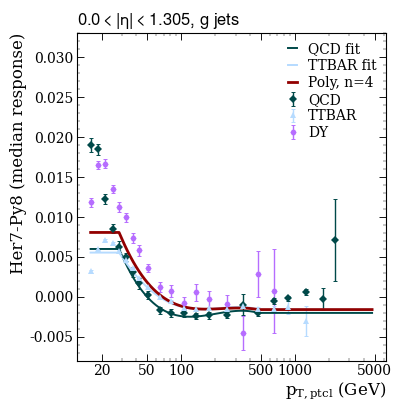

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta0p0to1p305_T_fits


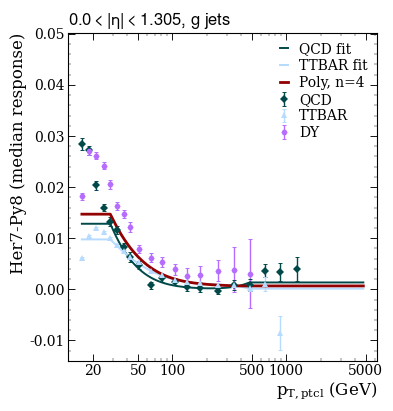

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta0p0to1p305_T_fits


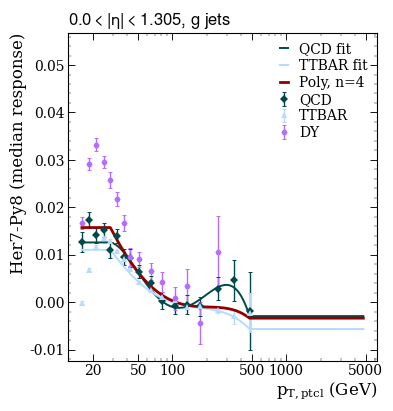

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta0p0to1p305_T_fits


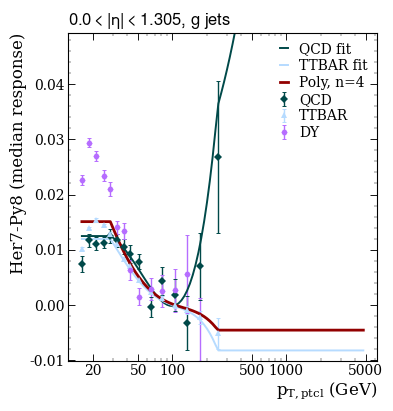

/tmp/anpotreb/ipykernel_27753/988653080.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, fit_samp='J' )


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta0p0to1p305_T_fits


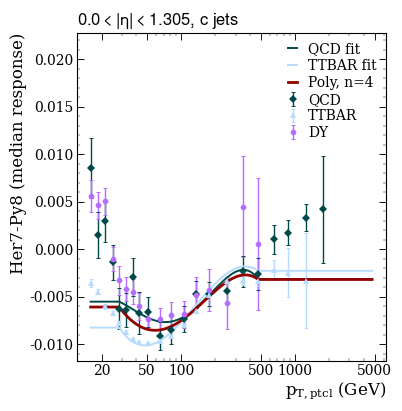

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta0p0to1p305_T_fits


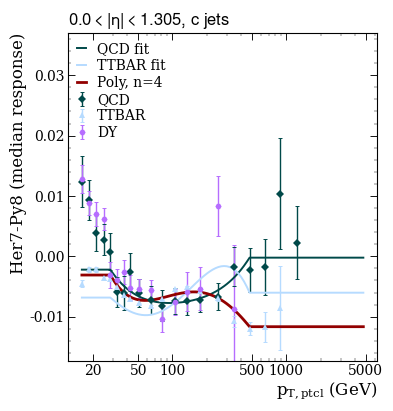

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta0p0to1p305_T_fits


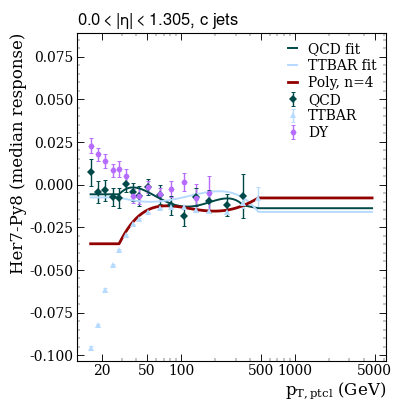

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta0p0to1p305_T_fits


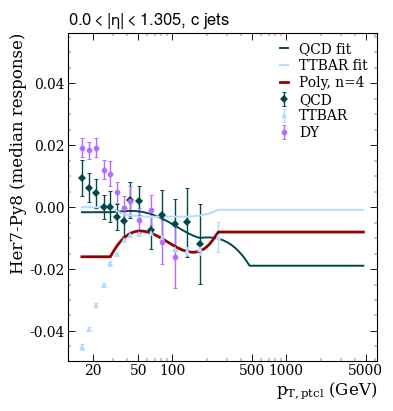

/tmp/anpotreb/ipykernel_27753/988653080.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, fit_samp='J' )


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta0p0to1p305_T_fits


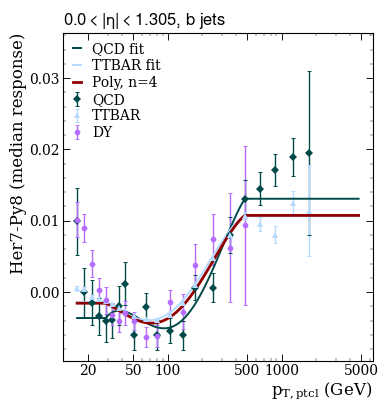

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta0p0to1p305_T_fits


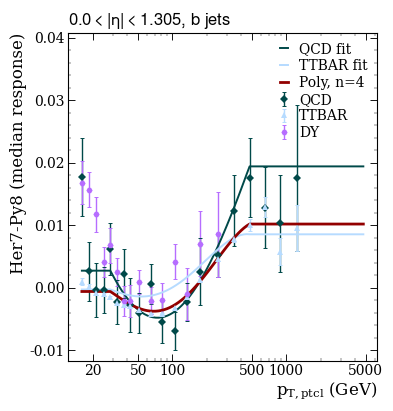

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta0p0to1p305_T_fits


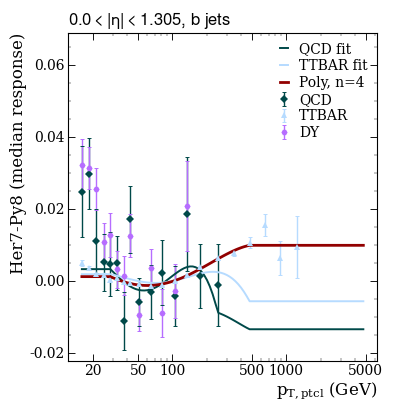

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta0p0to1p305_T_fits


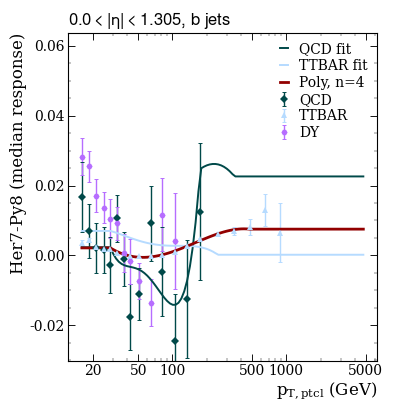

/tmp/anpotreb/ipykernel_27753/988653080.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, fit_samp='J' )


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_q_jets_eta0p0to1p305_T_fits


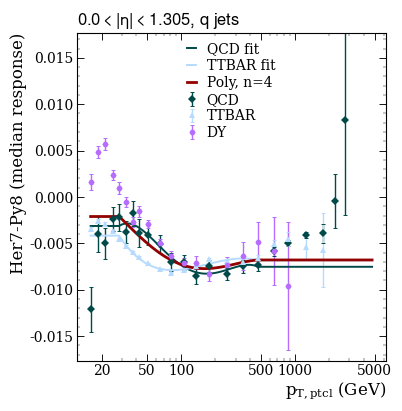

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_q_jets_eta0p0to1p305_T_fits


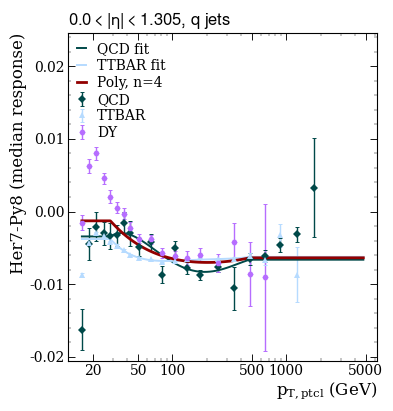

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_q_jets_eta0p0to1p305_T_fits


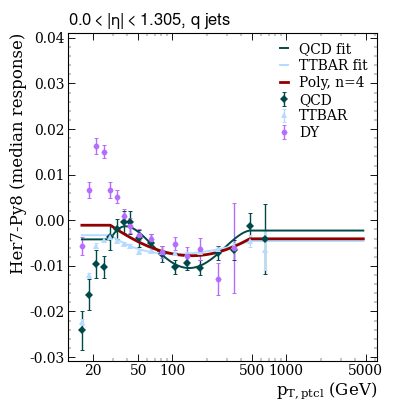

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_q_jets_eta0p0to1p305_T_fits


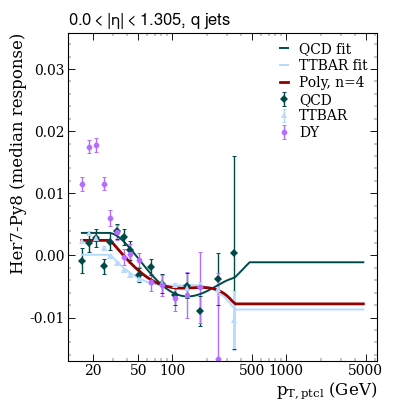

/tmp/anpotreb/ipykernel_27753/988653080.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, fit_samp='J' )


In [34]:
ratio_fits = {}
Her_Py_ratio_fit_res = RatioPlotFitRes(binning=eta_binning)
for flav in flavors[:4]:
    fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, fit_samp='J' ) 
                                for etaidx in range(jeteta_bins.nbins)])
    Her_Py_ratio_fit_res.add_flavor(flav, fit_res_tmp)
    
# def evaluate_Her_Py_ratio(etavals, ptvals, flav, etabins):
#     etaidxs = jeteta_bins.get_bin_idx(etavals)
#     if not isinstance(ptvals, Iterable):
#         ptvals = [ptvals]      
# #     if not (type(ptvals) is list) or (type(ptvals) is np.ndarray):
#     if not isinstance(etaidxs, Iterable): #(type(etaidx) is list) or (type(etaidx) is np.ndarray):
#         etaidxs = np.array([etaidxs])
        
#     etaidxs[etaidxs>=len(ratio_fits[flav])] = len(ratio_fits[flav])-1 
    
#     fit_res = ratio_fits[flav][etaidxs]
#     return np.array(
#         [poly4lims(np.array([ptval]), xfitmin, xfitmax, *p) 
#                for ptval, (p, xfitmin, xfitmax) in zip(ptvals, fit_res)]
#     ).T

In [35]:
# etavals, ptvals = [1,2,3,4], [20,30,30,40]
# Her_Py_ratio_fit_res.evaluate(flav, etavals, ptvals)
# # .evaluate(flav,etavals, ptvals)

In [36]:
def get_evaluator_pre(sample='Her', flavor='b' , inverse=False, use_corrections='J'):
    ''' inverse==True gets a correction, inverse==False gets a response.
    evaluator obtains corrections directly
    '''
    eva = evaluator[f'Summer20UL18_V2_MC_L5Flavor_AK4PFchs_{sample}{fineetastr}_pt30to500_{flavor}{use_corrections}']
    if inverse==True:
        return eva
    else:
        return lambda a,b: 1/eva(a,b)

In [37]:
# def limit_ptbins(ptvals, etavals, minpt=ptmin_global, maxpt=ptmax_global):
#     ### Hard coded limits for the uncertainties
#     if not isinstance(ptvals, Iterable):
#         ptvals = np.array([ptvals])      
#     if not isinstance(etavals, Iterable): #(type(etaidx) is list) or (type(etaidx) is np.ndarray):
#         etaidxs = np.array([etavals])
#     ptvals = ptvals.copy()
#     ptvals[ptvals<minpt]=minpt
#     ptvals[ptvals>maxpt]=maxpt
#     return ptvals, etavals

def resum_to_mix_one_flav(etavals, ptvals, Efracspline, samp, flav):
    response = get_evaluator(samp, flav)(etavals, ptvals)
    return response*Efracspline.evaluate(flav,etavals, ptvals)

def resum_to_mix_from_ratio_one_flav(etavals, ptvals, Efracspline, Efracspline2, flav):
    response = Her_Py_ratio_fit_res.evaluate(flav, etavals, ptvals )
    if Efracspline2==None:
        return response*Efracspline.evaluate(flav,etavals, ptvals)
    else:
        return response*(Efracspline.evaluate(flav,etavals, ptvals)+
                               Efracspline2.evaluate(flav,etavals, ptvals)/2)

def resum_to_mix(Efracspline, samp, etavals, ptvals):
    ''' Sum up the corrections from the fit according to the flavor fractions in `Efracspline`.
    samp = 'Her' or 'Py' for Herwig corrections or for Pythia corrections
    '''
    ptvals, etavals = convert_to_np_array(ptvals), convert_to_np_array(etavals)
    ptvals = np.clip(ptvals, ptmin_global, ptmax_global)
    
    
    spline_sum = sum(
        resum_to_mix_one_flav(etavals, ptvals, Efracspline, samp, flav ) for flav in flavors
    )
    return spline_sum

def resum_ratio_to_mix(etavals, ptvals, Efracspline, Efracspline2=None, divideHerPy=False, start_from_ratios=True):
    ''' Compute Eq. (26) in Sec. 7 of arXiv:1607.03663 at etavals and ptvals.
    Use flavor fractions splines given in Efracspline, Efracspline2.
    `divideHerPy` == True: calculate the Herwig/Pythia ratio; False: calculate the Herwig/Pythia difference
    `start_from_ratios` == True: resum the Herwig/Pythia ratios to the average of the flavor content;
                           False: do as in Eq. (26)
    '''
    
    ptvals, etavals = convert_to_np_array(ptvals), convert_to_np_array(etavals)
    ptvals = np.clip(ptvals, ptmin_global, ptmax_global)
    if start_from_ratios:
        spline_sum = sum(
            resum_to_mix_from_ratio_one_flav(etavals, ptvals, Efracspline, Efracspline2, flav )   for flav in flavors
        )
        return spline_sum.T
    else:
        return get_ratio(resum_to_mix(Efracspline, 'Her', etavals, ptvals),
                         resum_to_mix(Efracspline2, 'Py', etavals, ptvals),
                         divideHerPy)

def get_additional_uncertainty_curves(etavals, ptvals, etavals0, dijetat_eta0, start_from_ratios=True):
    '''Obtain all the other curves neccessary for the plots'''
    result = {}
    result["g20q80"] = resum_ratio_to_mix(etavals, ptvals,
                                          qfrac_spline_dict['_DY-MG-Her'],
                                          qfrac_spline_dict['_DY-MG-Py'],
                                          divideHerPy,
                                          start_from_ratios
                                         )
    result["g20q80_fixed"] = resum_ratio_to_mix(0, 200,
                                          qfrac_spline_dict['_DY-MG-Her'],
                                          qfrac_spline_dict['_DY-MG-Py'],
                                          divideHerPy,
                                          start_from_ratios
                                         )
    
    for flav in flavors:
        if start_from_ratios:
            result[flav+'100'] = Her_Py_ratio_fit_res.evaluate(flav, etavals, ptvals ).T
        else:
            result[flav+'100'] = get_ratio(
                                get_evaluator("Her", flav)(etavals, ptvals),
                                get_evaluator("Py",  flav)(etavals, ptvals),
                                divideHerPy
                                 ) 

    Rdijet0 = resum_ratio_to_mix(etavals0, ptvals,
                                  qfrac_spline_dict['_QCD-MG-Her'],
                                  qfrac_spline_dict['_QCD-MG-Py'],
                                  divideHerPy,
                                  start_from_ratios
                                )
    
    result["Rref"] = result["g20q80_fixed"] + (dijetat_eta0 - Rdijet0) #HerPy_differences['QCD'][0]
    
    return result
    
# def get_additional_uncertainty_curves_from_ratio(etavals, ptvals, etavals0):
#     result = {}
#     result["g20q80"] = resum_to_mix_from_ratio(etavals, ptvals,
#                                                qfrac_spline_dict['_DY-MG-Her'], qfrac_spline_dict['_DY-MG-Py'])
  
#     result["g20q80_fixed"] = resum_to_mix_from_ratio(0, 200,
#                                                qfrac_spline_dict['_DY-MG-Her'], qfrac_spline_dict['_DY-MG-Py'])
  
    
#     ptvals2 = ptvals.copy()
#     ptvals2[ptvals2<30]=30
#     ptvals2[ptvals2>500]=500
# #     pteta_grid = (np.log10(ptvals2), etavals)
    
#     for flav in ['q', 'g', 'b', 'c']:
#         result[flav+'100'] = 

#     Rdijet0 = resum_to_mix_from_ratio(etavals0, ptvals2,
#                                                qfrac_spline_dict['_QCD-MG-Her'], qfrac_spline_dict['_QCD-MG-Py'])
    
# #     fig, ax = plt.subplots()
# #     ax.plot(ptvals, Rdijet0)
# #     ax.set_xscale('log')

# #     fig, ax = plt.subplots()
# #     ax.plot(ptvals, result["g20q80_fixed"])
# #     ax.set_xscale('log')
    
#     result["Rref"] = result["g20q80_fixed"] + (HerPy_differences['QCD'][0] - Rdijet0)
    
#     return result

In [38]:
def create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=False):
    if inverse==True:
        a = read_corrections(sampHer, 'all')
        b = read_corrections(sampPy, 'all')
        delta_a = read_data2('MedianStd', sampHer, 'all')
        delta_b = read_data2('MedianStd', sampPy, 'all')
        corr_all = get_ratio(a, b, divideHerPy)[pt_idxs,eta_idxs]
        if divideHerPy:
            corrstd_all = np.sqrt((delta_a*b)**2+(delta_b*b**2/a)**2)[pt_idxs,eta_idxs]
        else:
            corrstd_all = np.sqrt((delta_a*a**2)**2+(delta_b*b**2)**2)[pt_idxs,eta_idxs]
    else:
        a = read_data2('Median', sampHer, 'all')
        b = read_data2('Median', sampPy, 'all')
        delta_a = read_data2('MedianStd', sampHer, 'all')
        delta_b = read_data2('MedianStd', sampPy, 'all')
        corr_all = get_ratio(a, b, divideHerPy)[pt_idxs,eta_idxs]
        if divideHerPy:
            corrstd_all = np.sqrt((delta_a/b)**2+(a/b**2*delta_b)**2)[pt_idxs,eta_idxs]
        else:
            corrstd_all = np.sqrt(delta_a**2+delta_b**2)[pt_idxs,eta_idxs]
    return [corr_all, corrstd_all]

In [39]:
def plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, ptoretastr, plotvspt=False):
    addc = additional_uncertainty_curves
    fig, ax = plt.subplots()

    xvals = ptvals if plotvspt else etavals
    old_uncs = []
    for samp in ['QCD', 'DY']:    
        old_unc = ax.plot(xvals, (uncertainties[samp](etavals, ptvals)[:,0]-1)*100, '-.', markersize=0, linewidth=1.0,
                **color_scheme[samp], alpha=0.6)
        ax.plot(xvals, (HerPy_differences[samp][0]-addc['Rref'])*100, linestyle=(2, (4, 2)), label=samp, markersize=0,
                linewidth=1.2, **color_scheme[samp])
        old_uncs.append(old_unc[0])

#     next(ax._get_lines.prop_cycler) ## allign colors with plot_HerPydiff (skip 20%glu)
    for flav in ['g', 'q', 'b', 'c']:
        lab = leggend_dict[flav]
        old_unc = ax.plot(xvals, (uncertainties[flav](etavals, ptvals)[:,0]-1)*100, '-.', markersize=0, linewidth=1.0,
                **color_scheme[flav], alpha=0.6)
        ax.plot(xvals, (addc[f'{flav}100']-addc['Rref'])*100, label=lab, markersize=0, linewidth=1.2,
                **color_scheme[flav])
        old_uncs.append(old_unc[0])
#     ax.plot(xvals, (addc['q100']-addc['Rref'])*100, label='Quarks', markersize=0, linewidth=1.2)
#     ax.plot(xvals, (addc['b100']-addc['Rref'])*100, label='Bottom', markersize=0, linewidth=1.2)
#     val_glu = flav_evaluator['Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_FlavorPureGluon'](etavals, ptvals)[:,0]
#     ax.plot(xvals, (1-val_glu)*100, label='Gluons old', markersize=0, linewidth=1.2)
    
    vlinecoord = 1 if divideHerPy else 0
    ax.hlines(vlinecoord, ax.get_xlim()[0], ax.get_xlim()[1],color="gray",
        linewidth=1, alpha=0.4)

#     legloc = 'upper left' if plotvspt else 'upper right'
#     legloc = 'upper left' if plotvspt else 'upper right'
    legend1 = ax.legend(old_uncs, ['']*len(old_uncs), loc='upper right', bbox_to_anchor=(0.52, 1), handlelength=1.5, title='Run 1', title_fontsize=10)
    leg2 = ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(0.47, 1), handlelength=0.9, title='Run 2' , title_fontsize=10)#, title='assembled\nfrom QCD', title_fontsize=10)
    ax.add_artist(legend1)
    xlabel = r'$p_{T}$ (GeV)' if plotvspt else r'$\eta$'
    ax.set_xlabel(xlabel);
    ylabel = 'JEC uncertainty (%)'
    ax.set_ylabel(ylabel);
    if plotvspt:
        ax.set_xscale('log')
        ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        ax.set_xlim(15,1000)

    # ax.set_ylim(0.9885,1.0205)
    ylim_old = ax.get_ylim()
    ylim_pad = (ylim_old[1]-ylim_old[0])*0.4 if plotvspt else (ylim_old[1]-ylim_old[0])*0.62
    ax.set_ylim(ylim_old[0],ylim_old[1]+ylim_pad)
    labtxt = f'$\eta$ = {ptoretastr}' if plotvspt else f'$p_T$ = {ptoretastr} GeV'
#     labtxt = f'$\eta$ = {etabins_abs[ptoretaidx]}' if plotvspt else f'$p_T$ = {ptbins_c[ptoretaidx]} GeV'
    hep.label.exp_text(text=labtxt, loc=0)
    figdir = "fig/uncertainty"
    if not os.path.exists(figdir):
        os.mkdir(figdir)

    if plotvspt:
        fig_name = figdir+f"/JECuncertainty_vs_pt_eta_{ptoretastr}".replace('.','')
    else:
        fig_name = figdir+f"/JECuncertainty_vs_pt_pt_{ptoretastr}".replace('.','_')
    fig_name = fig_name.replace(', ', '_')
    print("Saving plot with the name = ", fig_name+".pdf / .png")
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    plt.show()

    1;

In [40]:
def plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, etaidx, etabins):
    addc = additional_uncertainty_curves
    fig, ax = plt.subplots()

    lines = []
    markers = []
    for samp in ['QCD', 'DY', 'TTBAR']:    
#         mc = next(ax._get_lines.prop_cycler)
        line = ax.plot(ptvals, HerPy_differences[samp][0], linestyle=(0, (3.3, 2)), markersize=0, **color_scheme[samp], linewidth=1.2)
        marker = ax.errorbar(pt_bins.centres, HerPy_differences[samp][1], yerr=HerPy_differences[samp][2],
                           linestyle='none', **color_scheme[samp], capsize=1.6, capthick=0.7, linewidth=1.0)
        lines.append(line[0])
        markers.append(marker[0])
        
    pointsg20 = ax.plot(ptvals, addc['g20q80'], label='DY at 200 GeV', markersize=0, linewidth=1.2, **color_scheme["DY200"])
    for flav in ['g', 'q', 'b', 'c']:
        lab = leggend_dict[flav]
        ax.plot(ptvals, addc[f'{flav}100'], label=lab, markersize=0, linewidth=1.2, **color_scheme[flav])
#         ax.plot(ptvals, addc['q100'], label='Quarks', markersize=0, linewidth=1.2)
#         ax.plot(ptvals, addc['b100'], label='Bottom', markersize=0, linewidth=1.2)

    vlinecoord = 1 if divideHerPy else 0
    ax.hlines(vlinecoord ,1, 10000,color="gray",
        linewidth=1, alpha=0.4)

    ax.hlines(addc['g20q80_fixed'], 1, 10000, linestyles='--',color=color_scheme["DY200"]['color'],
        linewidth=1, alpha=0.9)

    leg1_handles = [(ai,bi) for ai, bi, in zip(lines,markers)]
    legend1 = ax.legend(leg1_handles, ['QCD', 'DY', 'TTBAR'], loc="upper right", bbox_to_anchor=(0.52, 1), handlelength=1.5) # seg.len=5) #, title='correction', title_fontsize=10)
#     assert False
    leg2 = ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(0.48, 1))#, title='assembled\nfrom QCD', title_fontsize=10)
    ax.add_artist(legend1)
    xlabel = r'$p_{T}$ (GeV)'
    ax.set_xlabel(xlabel);
    ylab_pre = 'Her7/Py8' if divideHerPy else 'Her7-Py8'
    ylabel = r' (correction)' if inverse else r' (median response)'
    ax.set_ylabel(ylab_pre+ylabel);
    ax.set_xscale('log')
    ax.set_xticks([10, 20, 50, 100, 500, 1000, 5000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    # ax.set_ylim(0.9885,1.0205)
    ax.set_xlim(15,1000)
    ylim_old = ax.get_ylim()
    ylim_pad = (ylim_old[1]-ylim_old[0])*0.3
    ax.set_ylim(ylim_old[0],ylim_old[1]+ylim_pad)

    hep.label.exp_text(text=jeteta_bins.idx2plot_str(etaidx), loc=0)

    figdir = "fig/uncertainty"
    if not os.path.exists(figdir):
        os.mkdir(figdir)
    add_name = '/Herwig_Pythia_ratio' if divideHerPy else '/Herwig_Pythia_difference'
    fig_name = figdir+add_name+jeteta_bins.idx2str(etaidx)
    print("Saving plot with the name = ", fig_name+".pdf / .png")
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    plt.show()

1;

In [41]:
# title_name = 'QCD' if fit_samp=='J' else 'ttbar'
# hep.label.exp_text(text=jeteta_bins.idx2plot_str()+f', {flav} jets', loc=0)

# figdir = "fig/uncertainty"
# if not os.path.exists(figdir):
#     os.mkdir(figdir)
# etastr = jeteta_bins.idx2str()
# fig_name = f'fig/uncertainty/Pythia_Herwig_all_samples_{flav}_jets_{etastr}_{fit_samp}_fits'
# print("Saving plot with the name = ", fig_name)

In [42]:
# qfrac_spline_dict[sampHer]['b'](pteta_grid).shape
# evaluate_Her_Py_ratio(etavals, ptvals, 'b').shape

In [43]:
# np.array(evaluate_Her_Py_ratio(etavals, ptvals, 'b'))

In [44]:
# plt.rcParams['figure.subplot.left'] = 0.18

In [45]:
# for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
#     if plotvspt:
#         ptvals = np.geomspace(ptbins_c.min(), ptbins_c.max(), 1000)
#         etaidx = np.searchsorted(etabins_c,plot_val)
# #         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
#         etavals = np.ones(len(ptvals))*etabins_c[etaidx]
#         pteta_grid = (np.log10(ptvals), etavals)
#         pt_idxs = range(len(ptbins_c))
#         eta_idxs = etaidx
#     else:    
#         etavals = np.linspace(etabins_c.min(),etabins_c.max(), 100)
#         ptidx = np.searchsorted(ptbins_c,plot_val)
#         ptvals = np.ones(len(etavals))*ptbins_c[etaidx]
#         pteta_grid = (np.log10(ptvals), etavals)
#         pt_idxs = ptidx
#         eta_idxs = range(len(etabins_abs))
    
    
#     additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0, pteta_grid0)

In [93]:
from coffea.lookup_tools import extractor
unc = ["* * Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor.junc.txt"]

ext = extractor()
ext.add_weight_sets(unc)
ext.finalize()
flav_evaluator = ext.make_evaluator()

# flav_evaluator['Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_FlavorPureGluon'](etavals, ptvals)[:,0]

/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/coffea/lookup_tools/txt_converters.py:166: UserWarning: binning for file for Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor_FlavorPureGluon is malformed in variable JetEta
  warnings.warn(
/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/coffea/lookup_tools/txt_converters.py:166: UserWarning: binning for file for Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor_FlavorPureQuark is malformed in variable JetEta
  warnings.warn(
/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/coffea/lookup_tools/txt_converters.py:166: UserWarning: binning for file for Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor_FlavorPureCharm is malformed in variable JetEta
  warnings.warn(
/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/coffea/lookup_tools/txt_converters.py:166: UserWarning: binning for file for Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor_FlavorPureBottom is malformed in variable JetEta
  warnings.warn(


In [94]:
lab_to_flav = {"DY" : "FlavorZJet",
               "QCD": "FlavorQCD",
               "GammaJet": "FlavorPhotonJet",
               "q":   "FlavorPureQuark",
               "c":   "FlavorPureCharm",
               "b":   "FlavorPureBottom",
               "g":   "FlavorPureGluon",
               }

# def get_uncertainties():
uncertainties = {key:flav_evaluator[f'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor_{lab_to_flav[key]}']
                   for key in lab_to_flav}

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_differenceeta0p0to1p305.pdf / .png


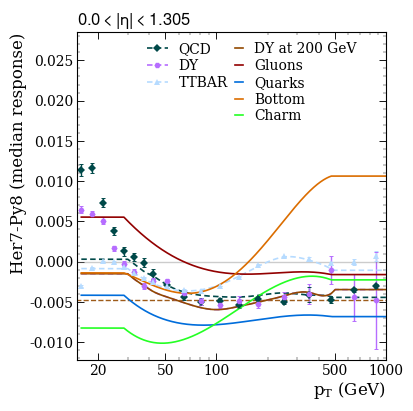

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 00<|\eta|<1305$.pdf / .png


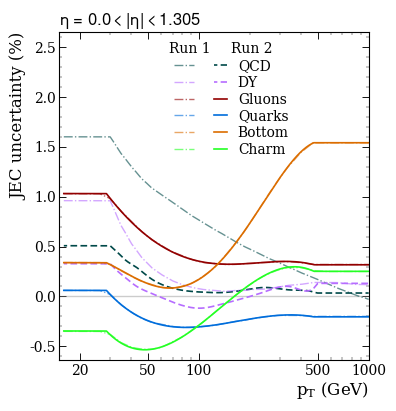

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_differenceeta1p305to2p5.pdf / .png


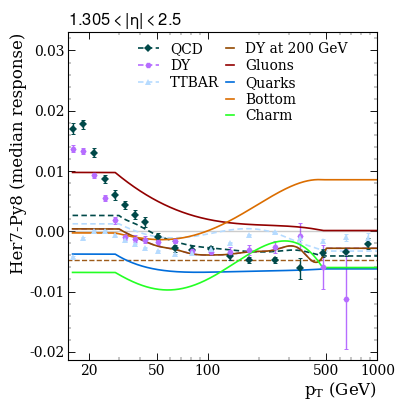

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 1305<|\eta|<25$.pdf / .png


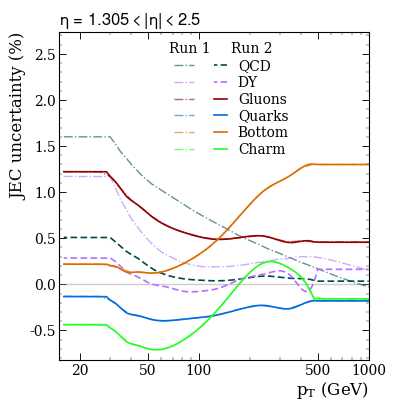

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_differenceeta2p5to3p139.pdf / .png


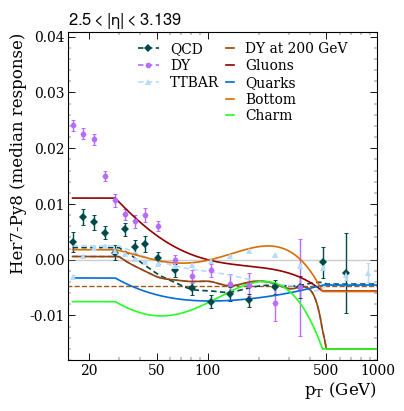

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 25<|\eta|<3139$.pdf / .png


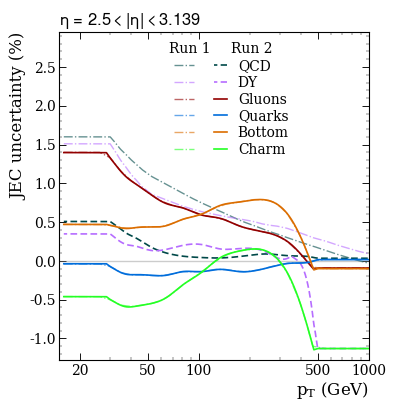

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_differenceeta3p139to5p191.pdf / .png


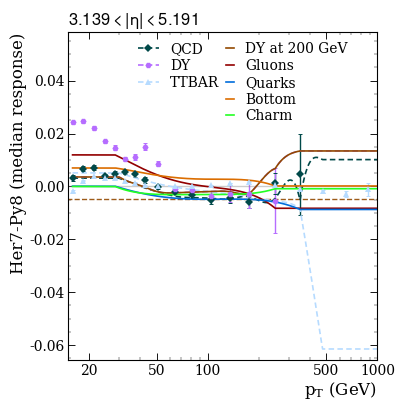

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 3139<|\eta|<5191$.pdf / .png


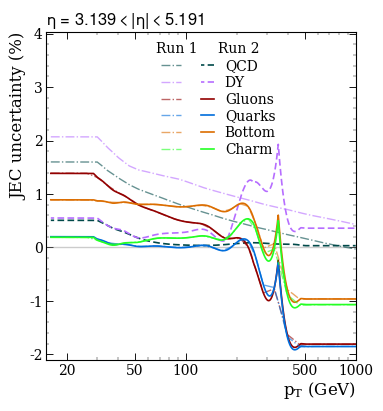

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_[16_].pdf / .png


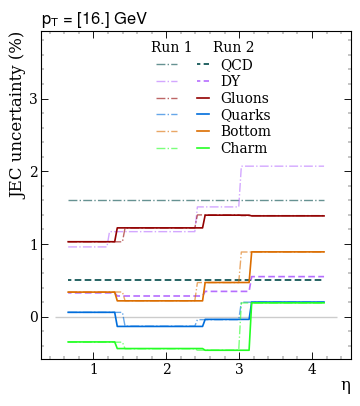

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_[21_5].pdf / .png


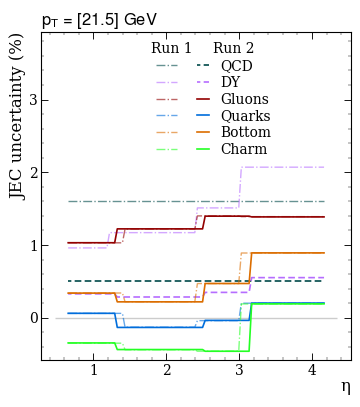

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_[32_5].pdf / .png


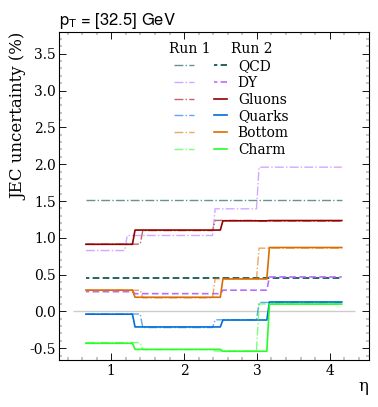

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_[51_].pdf / .png


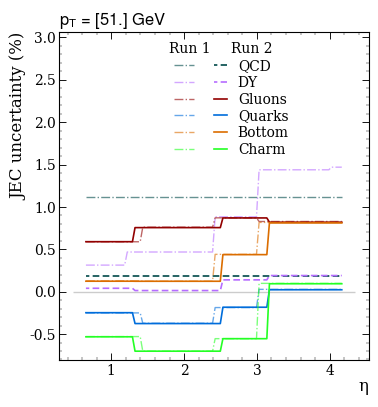

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_[105_].pdf / .png


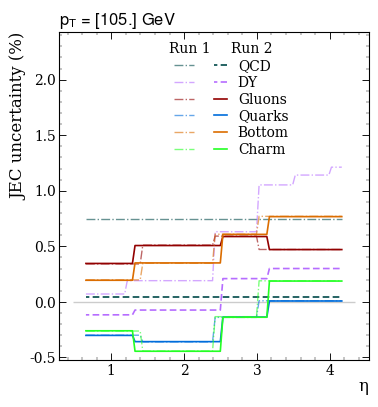

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_[350_].pdf / .png


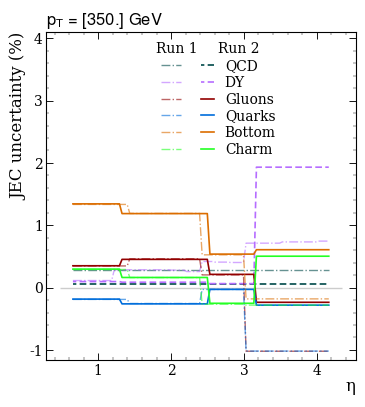

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_pt_[650_].pdf / .png


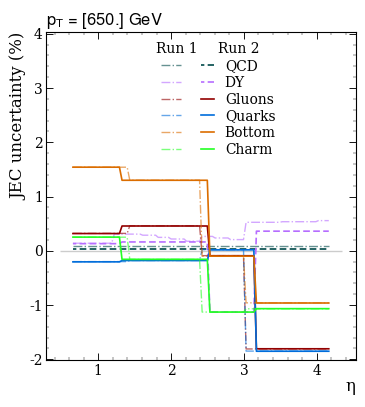

In [95]:
ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
etaplot_vals = jeteta_bins.centres #[16, 21.5, 32.5, 51, 105, 350, 650]


# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)+ptplot_vals
plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

inverse = False
divideHerPy = False #True
plotvspt = True
use_corrections = 'T'
start_from_ratios = False

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
#     print(f"plot val {plot_val}, plotvspt {plotvspt}")
    if plotvspt:
        ptvals = np.geomspace(pt_bins.centres.min(), pt_bins.centres.max(), 10000)
        idx = jeteta_bins.get_bin_idx(plot_val)
#         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
        etavals = np.ones(len(ptvals))*jeteta_bins.centres[idx]
        pt_idxs = range(pt_bins.nbins)
        eta_idxs = idx
    else:    
        etavals = np.linspace(jeteta_bins.centres.min(),jeteta_bins.centres.max(), 100)
        idx = pt_bins.get_bin_idx(plot_val)
        ptvals = np.ones(len(etavals))*pt_bins.centres[idx]
#         pteta_grid = (np.log10(ptvals), etavals)
        pt_idxs = idx
        eta_idxs = range(jeteta_bins.nbins)
    ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)
#     print('etaidx 1', idx)
#     pteta_grid = (np.log10(ptvals2), etavals)

    etaidx0=0 
    etavals0 = np.ones(len(ptvals2))*jeteta_bins.edges[etaidx0] ##Used to  obtain the eta dependance from dijet
#     etavals02 = np.ones(len(ptvals2))*etabins_c[etaidx0] ##Used to  obtain the eta dependance from dijet
#     pteta_grid0 = (np.log10(ptvals2), etavals02)

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
    Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']
    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]
#         HerPy_spline = get_ratio(resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid),
#               resum_to_mix(qfrac_spline_dict[sampPy], 'Py', etavals, ptvals, pteta_grid),
#               divideHerPy)
        HerPy_spline = resum_ratio_to_mix(etavals, ptvals,
                                          qfrac_spline_dict[sampHer],
                                          qfrac_spline_dict[sampPy],
                                          divideHerPy, start_from_ratios=start_from_ratios)
#         HerPy_spline = resum_to_mix(etavals, ptvals,
#                                                qfrac_spline_dict[sampHer], qfrac_spline_dict[sampPy])

#         print()
        corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=inverse)

        HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]


#     additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0, pteta_grid0)
    additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0,
                                                                      HerPy_differences['QCD'][0],
                                                                      start_from_ratios=start_from_ratios)
#     get_additional_uncertainty_curves_from_ratio(etavals, ptvals, etavals0)
    if plotvspt:
        plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx, jeteta_bins)
    
    if not divideHerPy:
#         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
        ptoretastr = jeteta_bins.idx2plot_str(idx) if plotvspt else pt_bins.centres[idx]
        plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, ptoretastr, plotvspt=plotvspt)

In [49]:
# ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = [2.8195-0.001] 
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]


# # ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

# plot_vals = list(etaplot_vals)+ptplot_vals
# plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

# inverse = False
# divideHerPy = False #True
# plotvspt = True
# use_corrections = 'T'

# def get_evaluator(sample='Her', flavor='b'):
#     return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

# for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
# #     print(f"plot val {plot_val}, plotvspt {plotvspt}")
#     if plotvspt:
#         ptvals = np.geomspace(ptbins_c.min(), ptbins_c.max(), 1000)
#         idx = np.searchsorted(etabins_c,plot_val)
# #         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
#         etavals = np.ones(len(ptvals))*etabins_c[idx]
#         pt_idxs = range(len(ptbins_c))
#         eta_idxs = idx
#     else:    
#         etavals = np.linspace(etabins_c.min(),etabins_c.max(), 100)
#         idx = np.searchsorted(ptbins_c,plot_val)
#         ptvals = np.ones(len(etavals))*ptbins_c[idx]
# #         pteta_grid = (np.log10(ptvals), etavals)
#         pt_idxs = idx
#         eta_idxs = range(len(etabins_abs)-1)

#     ptbins2 = np.clip(ptbins2, ptmin_global, ptmax_global)

#     etaidx0=0 
#     etavals0 = np.ones(len(ptvals2))*etabins_abs[etaidx0] ##Used to  obtain the eta dependance from dijet

#     samples = ['QCD', 'DY', 'TTBAR']
#     Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
#     Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']
#     HerPy_differences = {}
#     for ii in range(len(samples)):  
#         sampHer = Her_samples[ii]
#         sampPy = Py_samples[ii]
#         samp = samples[ii]
# #         HerPy_spline = get_ratio(resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid),
# #               resum_to_mix(qfrac_spline_dict[sampPy], 'Py', etavals, ptvals, pteta_grid),
# #               divideHerPy)
#         HerPy_spline = resum_ratio_to_mix(etavals, ptvals,
#                                           qfrac_spline_dict[sampHer],
#                                           qfrac_spline_dict[sampPy],
#                                           divideHerPy, start_from_ratios=True)
# #         HerPy_spline = resum_to_mix(etavals, ptvals,
# #                                                qfrac_spline_dict[sampHer], qfrac_spline_dict[sampPy])

#         corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=inverse)

#         HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]


# #     additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0, pteta_grid0)
#     additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0,
#                                                                       HerPy_differences['QCD'][0],
#                                                                       start_from_ratios=True)
# #     get_additional_uncertainty_curves_from_ratio(etavals, ptvals, etavals0)
#     if plotvspt:
#         plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx)
    
#     if not divideHerPy:
# #         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
#         ptoretastr = f'[{np.round(etabins_uncert[idx],3)}, {np.round(etabins_uncert[idx+1],3)}]' if plotvspt else ptbins_c[idx]
#         plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, ptoretastr, plotvspt=plotvspt)

In [50]:
# # etabins_uncert = np.array([-5.4, -5. , -4.4, -4. , -3.5, -3. , -2.8, -2.6, -2.4, -2.2, -2. ,
# #        -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,
# #         0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,
# #         2.6,  2.8,  3. ,  3.5,  4. ,  4.4,  5. ,  5.4])

# etabins_uncert = np.array([0. ,  0.2,
#         0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,
#         2.6,  2.8,  3. ,  3.5,  4. ,  4.4,  5. ,  5.4])

# # etains_abs = etabins_uncert

# ptbins_uncert = np.array([   9. ,   11. ,   13.5,   16.5,   19.5,   22.5,   26. ,   30. ,
#          34.5,   40. ,   46. ,   52.5,   60. ,   69. ,   79. ,   90.5,
#         105.5,  123.5,  143. ,  163.5,  185. ,  208. ,  232.5,  258.5,
#         286. ,  331. ,  396. ,  468.5,  549.5,  639. ,  738. ,  847.5,
#         968.5, 1102. , 1249.5, 1412. , 1590.5, 1787. , 2003. , 2241. ,
#        2503. , 2790.5, 3107. , 3455. , 3837. , 4257. , 4719. , 5226.5,
#        5784. , 6538. ])

# etavals_unc_lo = etabins_uncert[:-1]
# etavals_unc_hi = etabins_uncert[1:]
# etavals_unc_c = (etavals_unc_hi+etavals_unc_lo)/2

# ptbins_c_corr = ptbins_c
# ptbins_c = ptbins_uncert



In [51]:
jeteta_bins_unc = JetEtaBins("Uncert")
pt_bins_unc = PtBins("Uncert")

In [52]:
# etavals
# ptvals

In [53]:
# HerPy_spline

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 00<|\eta|<02$.pdf / .png


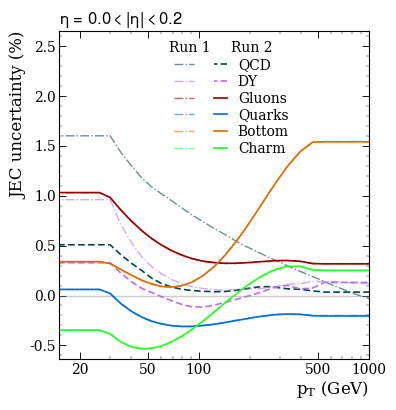

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 02<|\eta|<04$.pdf / .png


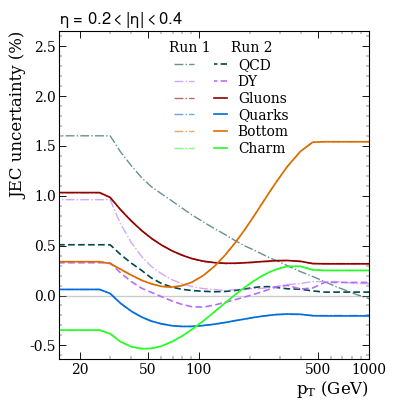

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 04<|\eta|<06$.pdf / .png


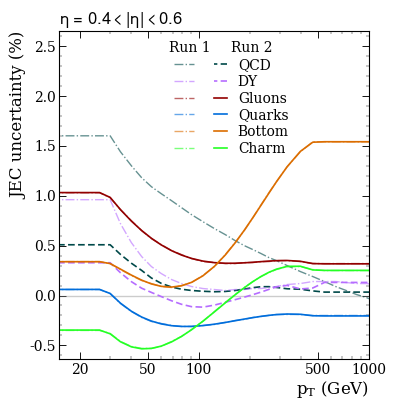

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 06<|\eta|<08$.pdf / .png


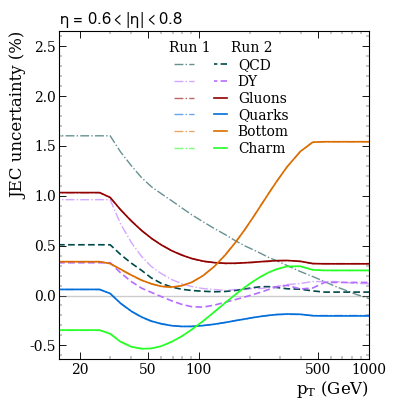

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 08<|\eta|<10$.pdf / .png


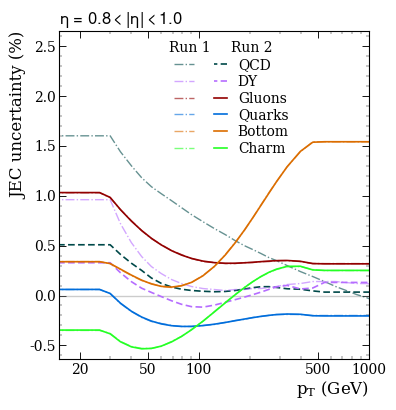

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 10<|\eta|<12$.pdf / .png


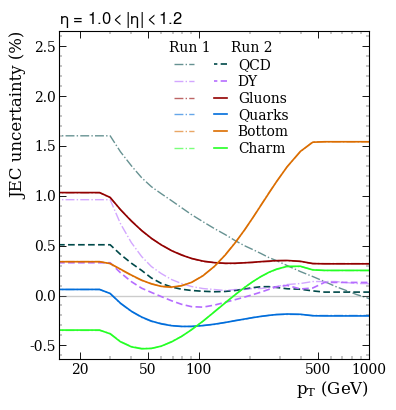

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 12<|\eta|<14$.pdf / .png


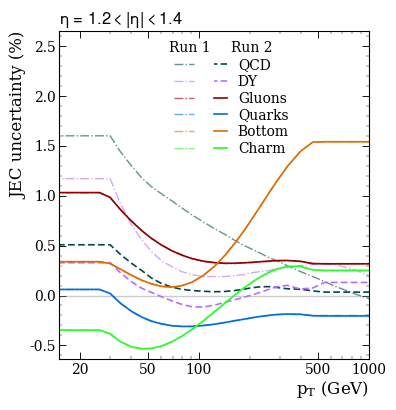

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 14<|\eta|<16$.pdf / .png


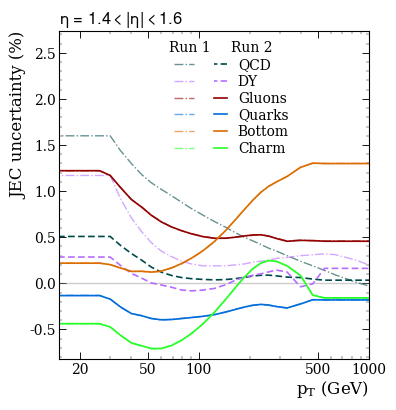

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 16<|\eta|<18$.pdf / .png


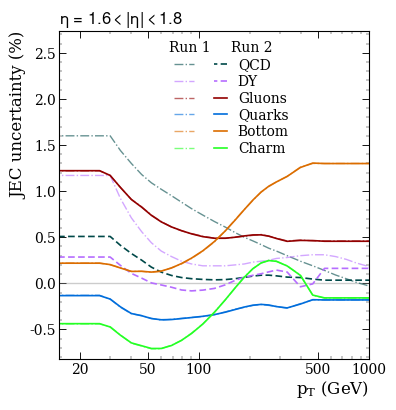

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 18<|\eta|<20$.pdf / .png


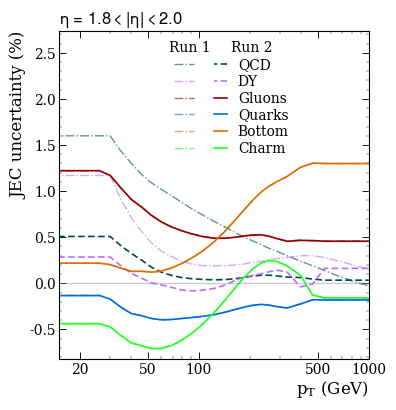

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 20<|\eta|<22$.pdf / .png


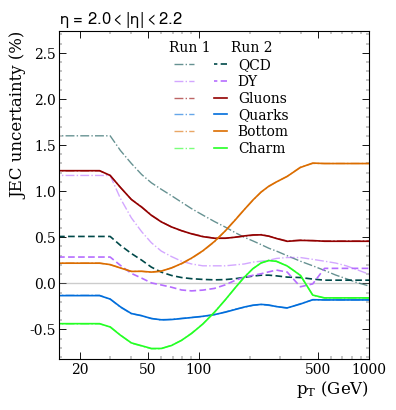

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 22<|\eta|<24$.pdf / .png


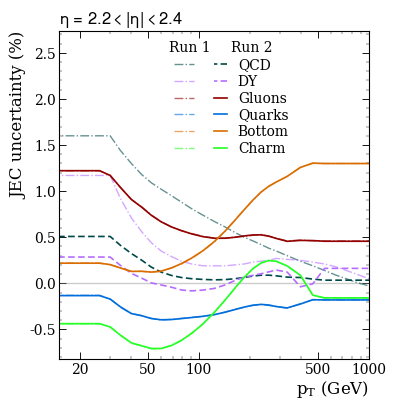

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 24<|\eta|<26$.pdf / .png


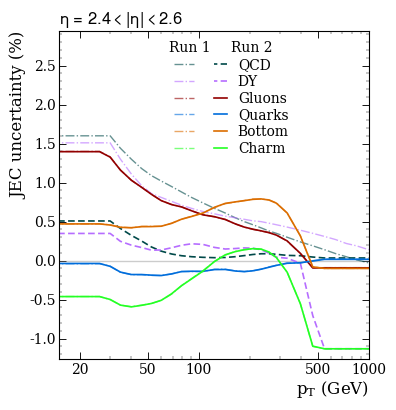

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 26<|\eta|<28$.pdf / .png


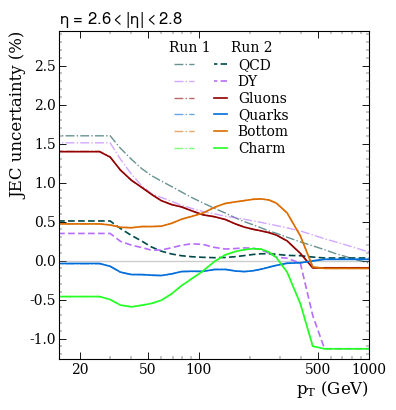

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 28<|\eta|<30$.pdf / .png


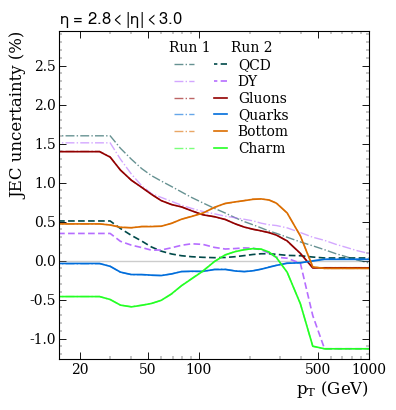

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 30<|\eta|<35$.pdf / .png


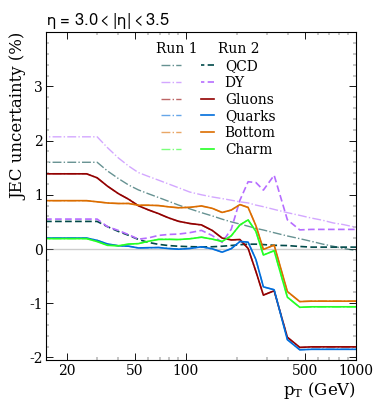

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 35<|\eta|<40$.pdf / .png


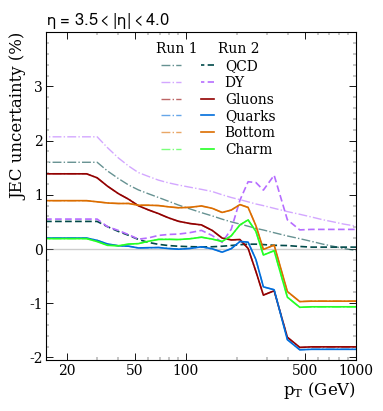

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 40<|\eta|<44$.pdf / .png


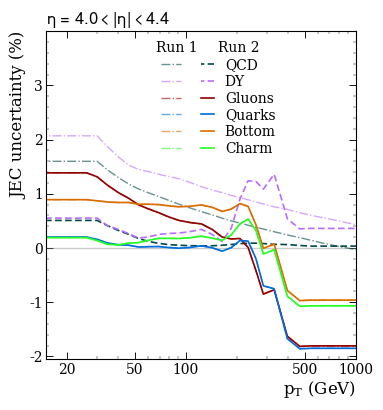

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 44<|\eta|<50$.pdf / .png


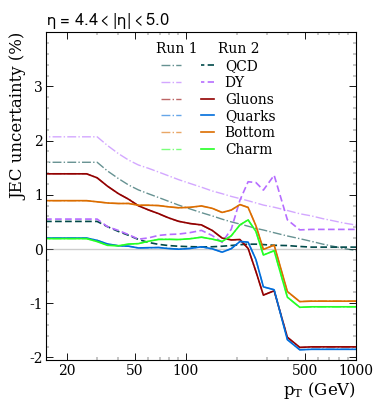

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_$ 50<|\eta|<54$.pdf / .png


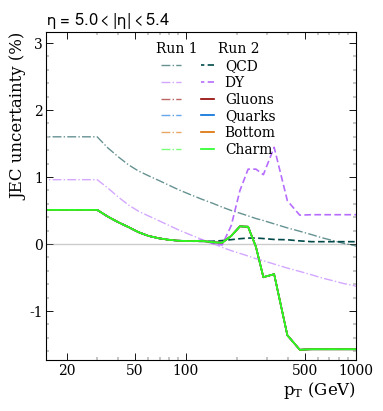

In [54]:
ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
jeteta_bins_loc = jeteta_bins_unc
pt_bins_loc = pt_bins_unc

etaplot_vals = jeteta_bins_loc.centres #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)+ptplot_vals
plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

inverse = False
divideHerPy = False #True
plotvspt = True
use_corrections = 'T'
start_from_ratios = False

uncert_to_save = {flav: np.array([None]*pt_bins_loc.nbins) for flav in flavors}

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

for plot_val in plot_vals:
    ptvals = pt_bins_loc.centres
#         ptvals = np.geomspace(pt_bins_loc.centres.min(), pt_bins_loc.centres.max(), 1000)
    idx = jeteta_bins_loc.get_bin_idx(plot_val)
    etavals = np.ones(len(ptvals))*jeteta_bins_loc.centres[idx]
    pt_idxs = range(pt_bins_loc.nbins)
    eta_idxs = idx
    ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)

    etaidx0=0 
    etavals0 = np.ones(len(ptvals2))*jeteta_bins_loc.edges[etaidx0] ##Used to  obtain the eta dependance from dijet

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
    Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']
    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]
        HerPy_spline = resum_ratio_to_mix(etavals, ptvals,
                                          qfrac_spline_dict[sampHer],
                                          qfrac_spline_dict[sampPy],
                                          divideHerPy, start_from_ratios=start_from_ratios)
#         corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=inverse)

        HerPy_differences[samp] = [HerPy_spline, None, None]


    additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0,
                                                                      HerPy_differences['QCD'][0],
                                                                      start_from_ratios=start_from_ratios)
    
    for flav in flavors:
        uncert_to_save[flav] = np.vstack([uncert_to_save[flav], additional_uncertainty_curves[flav+'100']-additional_uncertainty_curves['Rref']])
    
    ptoretastr = jeteta_bins_loc.idx2plot_str(idx) if plotvspt else pt_bins_loc.centres[idx]
    plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, ptoretastr, plotvspt=plotvspt)
#     if plotvspt:
#         plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx, jeteta_bins_loc)
    
#     if not divideHerPy:
#         ptoretastr = jeteta_bins_loc.idx2plot_str(idx) if plotvspt else pt_bins_loc.centres[idx]
#         plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, ptoretastr, plotvspt=plotvspt)

for flav in flavors:
    uncert_to_save[flav] = uncert_to_save[flav][1:]

In [55]:
# additional_uncertainty_curves['q100']


In [56]:
# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = [2.8195-0.001] 
# etaplot_vals = etavals_unc_c #etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]
# etabins_c = etavals_unc_c


# # ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

# plot_vals = list(etaplot_vals)+ptplot_vals
# plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

# inverse = False
# divideHerPy = False #True
# plotvspt = True
# use_corrections = 'T'

# def get_evaluator(sample='Her', flavor='b'):
#     return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

# for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
# #     print(f"plot val {plot_val}, plotvspt {plotvspt}")
#     if plotvspt:
#         ptvals = np.geomspace(ptbins_c.min(), ptbins_c.max(), 1000)
#         idx = np.searchsorted(etabins_c,plot_val)
# #         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
#         etavals = np.ones(len(ptvals))*etabins_c[idx]
#         pt_idxs = range(len(ptbins_c))
#         eta_idxs = idx
#     else:    
#         etavals = np.linspace(etabins_c.min(),etabins_c.max(), 100)
#         idx = np.searchsorted(ptbins_c,plot_val)
#         ptvals = np.ones(len(etavals))*ptbins_c[idx]
#         pteta_grid = (np.log10(ptvals), etavals)
#         pt_idxs = idx
#         eta_idxs = range(len(etabins_abs)-1)

#     ptbins2 = np.clip(ptbins2, ptmin_global, ptmax_global)
#     pteta_grid = (np.log10(ptvals2), etavals)

#     etaidx0=0 
#     etavals0 = np.ones(len(ptvals2))*etabins_abs[etaidx0] ##Used to  obtain the eta dependance from dijet
#     etavals02 = np.ones(len(ptvals2))*etabins_c[etaidx0] ##Used to  obtain the eta dependance from dijet
#     pteta_grid0 = (np.log10(ptvals2), etavals02)

#     samples = ['QCD', 'DY', 'TTBAR']
#     Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
#     Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']
#     HerPy_differences = {}
#     for ii in range(len(samples)):  
#         sampHer = Her_samples[ii]
#         sampPy = Py_samples[ii]
#         samp = samples[ii]
#         HerPy_spline = resum_ratio_to_mix(etavals, ptvals,
#                                           qfrac_spline_dict[sampHer],
#                                           qfrac_spline_dict[sampPy],
#                                           divideHerPy, start_from_ratios=True)
        
#         HerPy_differences[samp] = [HerPy_spline.T, None, None]
        
#     additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0,
#                                                                       HerPy_differences['QCD'][0],
#                                                                       start_from_ratios=True)

#     ptoretastr = f'[{np.round(etabins_uncert[idx],3)}, {np.round(etabins_uncert[idx+1],3)}]' if plotvspt else ptbins_c[idx]
#     plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, ptoretastr, plotvspt=plotvspt)
# #     plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, idx, plotvspt=plotvspt)

In [57]:
new_uncertainties = {'Flavor'+key1: uncert_to_save[key2] for key1, key2 in zip(['PureGluon', 'PureCharm', 'PureBottom', 'PureQuark'], flavors) } # ['QCD', 'ZJet', 'PureGluon', 'PureQuark', 'PureCharm', 'PureBottom'] }
# unc_names = ['QCD', 'DY']

In [58]:
# # jeteta_bins_unc.edges
# range(jeteta_bins_unc.nbins,1)
# range(jeteta_bins_unc.nbins)
# jeteta_bins_unc.nbins

In [68]:
pt_bins_unc.nbins*3

150

In [86]:
# [jeteta_bins_unc.edges[0], jeteta_bins_unc.edges[1]]
new_uncertainties = {}
for name, flav in zip(['PureGluon', 'PureCharm', 'PureBottom', 'PureQuark'], flavors):
    neg_etabins = [[-jeteta_bins_unc.edges[idx+1], -jeteta_bins_unc.edges[idx], pt_bins_unc.nbins*3] +
          list(np.column_stack((pt_bins_unc.centres, uncert_to_save[flav][idx], uncert_to_save[flav][idx])).reshape(-1))
    for idx in range(jeteta_bins_unc.nbins-1, -1, -1)]
    
    pos_etabins = [[jeteta_bins_unc.edges[idx], jeteta_bins_unc.edges[idx+1], pt_bins_unc.nbins*3] +
          list(np.column_stack((pt_bins_unc.centres, uncert_to_save[flav][idx], uncert_to_save[flav][idx])).reshape(-1))
    for idx in range(jeteta_bins_unc.nbins)]
    new_uncertainties ['Flavor'+name] = np.array(neg_etabins + pos_etabins)
    
    
    

In [75]:
# for idx in range(jeteta_bins_unc.nbins-1, -1, -1):
#     print([-jeteta_bins_unc.edges[idx+1], -jeteta_bins_unc.edges[idx]])
# # new_uncertainties['FlavorPureGluon'][15][:10]
# # new_uncertainties['FlavorPureGluon'][-16][:10]

In [76]:
def update_flavor_uncertainty_file(file_path, new_uncertainties):
    matched_section = False
    with open(file_path, 'r') as file:
        lines = file.readlines()

    output_lines = []
    i = 0
    while i < len(lines):
        line = lines[i]
        if line.startswith("["):
            section_title = line.strip()[1:-1]
            matched_section = section_title in new_uncertainties
            if matched_section:
                print('replacing secion:', section_title)
                output_lines.append(f'[{section_title}]\n')
                output_lines.append('{1 JetEta 1 JetPt "" Correction JECSource} \n')
                values = new_uncertainties[section_title]
                for value_row in values:
#                     output_lines.append(value_row+'\n')
                    output_lines.append(' '.join(map(str, np.round(value_row,4))) + '\n')

#                     output_lines.append('\n'.join(map(str, value_row)) + '\n')
                i += len(values)
            else:
                print('compying secion:', section_title)
                output_lines.append(line)
        elif not matched_section:
            output_lines.append(line)
        i += 1
    outfilename = file_path[:-4]+'_run2flavor.txt'
    print(f"Writing to a file '{outfilename}'")
    with open(outfilename, 'w') as file:
        file.writelines(output_lines)

In [92]:
# np.array(neg_etabins)[:,:3]

In [91]:
# new_uncertainties['FlavorPureBottom'][:,:3]

In [90]:
update_flavor_uncertainty_file('Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.txt', new_uncertainties)

compying secion: AbsoluteStat
compying secion: AbsoluteScale
compying secion: AbsoluteSample
compying secion: AbsoluteFlavMap
compying secion: AbsoluteMPFBias
compying secion: Fragmentation
compying secion: SinglePionECAL
compying secion: SinglePionHCAL
compying secion: FlavorQCD
compying secion: TimePtEta
compying secion: RelativeJEREC1
compying secion: RelativeJEREC2
compying secion: RelativeJERHF
compying secion: RelativePtBB
compying secion: RelativePtEC1
compying secion: RelativePtEC2
compying secion: RelativePtHF
compying secion: RelativeBal
compying secion: RelativeSample
compying secion: RelativeFSR
compying secion: RelativeStatFSR
compying secion: RelativeStatEC
compying secion: RelativeStatHF
compying secion: PileUpDataMC
compying secion: PileUpPtRef
compying secion: PileUpPtBB
compying secion: PileUpPtEC1
compying secion: PileUpPtEC2
compying secion: PileUpPtHF
compying secion: PileUpMuZero
compying secion: PileUpEnvelope
compying secion: SubTotalPileUp
compying secion: SubT

In [184]:
# (array([  16. ,   18.5,   21.5,   25. ,   28.5,   32.5,   37.5,   42.5,
#          51. ,   64.5,   81. ,  105. ,  135. ,  175. ,  250. ,  350. ,
#         475. ,  650. ,  875. , 1250. , 1750. , 2250. , 2750. , 3250. ,
#        3750. , 4250. , 4750. , 7500. ]), 2)

In [183]:
sampHer = '_Herwig-TTBAR'
sampPy = '_QCD-MG-Py'

use_corrections = 'T'

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

yval = resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid)

closure = read_data2('Median', sampPy, 'all')[:,0]
a = read_data2('Median', sampHer, 'all')[:,0] #/closure
delta_a = read_data2('MedianStd', sampHer, 'all')[:,0]
fig, ax = plt.subplots()
ax.plot(ptvals, yval, markersize=0, linewidth=1.2)
ax.plot(ptbins_c, a, linewidth=0)
ax.set_xscale('log')

# corr_all = get_ratio(a, b, divideHerPy)[pt_idxs,eta_idxs]
# if divideHerPy:
#     corrstd_all = np.sqrt((delta_a/b)**2+(a/b**2*delta_b)**2)[pt_idxs,eta_idxs]
# else:
#     corrstd_all = np.sqrt(delta_a**2+delta_b**2)[pt_idxs,eta_idxs]
# return [corr_all, corrstd_all]

NameError: name 'pteta_grid' is not defined

In [ ]:
sampHer = '_QCD-MG-Her'
sampPy = '_QCD-MG-Py'

use_corrections = 'J'

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

yval = resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid)

closure = read_data2('Median', sampPy, 'all')[:,0]
a = read_data2('Median', sampHer, 'all')[:,0]/closure
delta_a = read_data2('MedianStd', sampHer, 'all')[:,0]
fig, ax = plt.subplots()
ax.plot(ptvals, yval, markersize=0, linewidth=1.2)
ax.plot(ptbins_c, a, linewidth=0)
ax.set_xscale('log')

# corr_all = get_ratio(a, b, divideHerPy)[pt_idxs,eta_idxs]
# if divideHerPy:
#     corrstd_all = np.sqrt((delta_a/b)**2+(a/b**2*delta_b)**2)[pt_idxs,eta_idxs]
# else:
#     corrstd_all = np.sqrt(delta_a**2+delta_b**2)[pt_idxs,eta_idxs]
# return [corr_all, corrstd_all]

In [ ]:
ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
etaplot_vals =  etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)+ptplot_vals
plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

inverse = False
divideHerPy = False
plotvspt = False
use_corrections = 'J'

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
    if plotvspt:
        ptvals = np.geomspace(ptbins_c.min(), ptbins_c.max(), 1000)
        idx = np.searchsorted(etabins_c,plot_val)
#         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
        etavals = np.ones(len(ptvals))*etabins_c[idx]
        pteta_grid = (np.log10(ptvals), etavals)
        pt_idxs = range(len(ptbins_c))
        eta_idxs = idx
    else:    
        etavals = np.linspace(etabins_c.min(),etabins_c.max(), 100)
        idx = np.searchsorted(ptbins_c,plot_val)
        ptvals = np.ones(len(etavals))*ptbins_c[idx]
        pteta_grid = (np.log10(ptvals), etavals)
        pt_idxs = idx
        eta_idxs = range(len(etabins_abs))

    etaidx0=0 
    etavals0 = np.ones(len(ptvals))*etabins_abs[etaidx0] ##Used to  obtain the eta dependance from dijet
    etavals02 = np.ones(len(ptvals))*etabins_c[etaidx0] ##Used to  obtain the eta dependance from dijet
    pteta_grid0 = (np.log10(ptvals), etavals02)

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
    Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']

    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]
        HerPy_spline = get_ratio(resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid),
              resum_to_mix(qfrac_spline_dict[sampPy], 'Py', etavals, ptvals, pteta_grid),
              divideHerPy)

        corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=inverse)

        HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]


    additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0, pteta_grid0)
    
    if plotvspt:
        plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx)
    
    if not divideHerPy:
#         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
        plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, idx, plotvspt=plotvspt)

In [ ]:
fig, ax = plt.subplots()
ax.plot(ptvals, get_ratio(
                                get_evaluator("Her", 'b')(etavals, ptvals),
                                get_evaluator("Py",  'b')(etavals, ptvals),
                                divideHerPy
                                 ) 
       )

ax.plot(ptvals, get_evaluator("Her", 'b')(etavals, ptvals)-1)
ax.plot(ptvals, get_evaluator("Py", 'b')(etavals, ptvals)-1)
ax.set_xscale('log')